In [1]:
import torch

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU count:", torch.cuda.device_count())
    print("GPU name:", torch.cuda.get_device_name(0))


PyTorch version: 2.5.1+cu121
CUDA available: True
GPU count: 1
GPU name: NVIDIA GeForce RTX 3050 Laptop GPU


In [3]:

import os
import glob
import time
import random
import numpy as np
import cv2
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast, GradScaler
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp

In [4]:

#  CONFIG 

ROOT = r"d:/Image_forgery_detection/Data"
IMG_SIZE = 256
BATCH_SIZE = 8
NUM_WORKERS = 0           # Windows-safe
EPOCHS = 15
LR = 1e-4
SEED = 42
ENCODER = "efficientnet-b0"
PRETRAINED = True
SAVE_PATH = "best_hybrid_windows_fix.pth"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CLIP_GRAD_NORM = 5.0     # gradient clipping

# reproducibility

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

AUTOCAST_DEVICE = "cuda" if DEVICE.type == "cuda" else "cpu"

print("DEVICE:", DEVICE, "torch:", torch.__version__, "autocast device:", AUTOCAST_DEVICE)

DEVICE: cuda torch: 2.5.1+cu121 autocast device: cuda


In [5]:
#  Utility: list images with multiple extensions 

def list_images(folder):
    exts = ["*.png", "*.jpg", "*.jpeg", "*.PNG", "*.JPG", "*.JPEG"]
    files = []
    for e in exts:
        files.extend(glob.glob(os.path.join(folder, e)))
    return sorted(files)

# Build file list 

auth_dir = os.path.join(ROOT, "train_images", "authentic")
forg_dir = os.path.join(ROOT, "train_images", "forged")
mask_dir = os.path.join(ROOT, "train_masks")

assert os.path.exists(auth_dir), f"Missing folder {auth_dir}"
assert os.path.exists(forg_dir), f"Missing folder {forg_dir}"
assert os.path.exists(mask_dir), f"Missing folder {mask_dir}"

auth_list = list_images(auth_dir)
forg_list = list_images(forg_dir)
mask_list = glob.glob(os.path.join(mask_dir, "*.npy"))
mask_dict = { os.path.basename(p).rsplit(".",1)[0] : p for p in mask_list }

items = []
# authentic (label 0)
for p in auth_list:
    items.append((p, None, 0))
# forged (label 1)
for p in forg_list:
    base = os.path.basename(p).rsplit(".",1)[0]
    m = mask_dict.get(base, None)
    if m is None:
        # include without mask but warn
        print("WARN: missing mask for", base)
    items.append((p, m, 1))

print(f"TOTAL images: {len(items)}  masks(found): {sum(1 for it in items if it[1] is not None)}")

TOTAL images: 10256  masks(found): 5502


In [6]:
#  Split 

img_paths = [it[0] for it in items]
mask_paths = [it[1] for it in items]
labels = [it[2] for it in items]

train_imgs, val_imgs, train_masks, val_masks, train_labels, val_labels = train_test_split(
    img_paths, mask_paths, labels, test_size=0.2, stratify=labels, random_state=SEED
)

print("Train/Val:", len(train_imgs), "/", len(val_imgs))
print("Train forged ratio:", sum(train_labels)/len(train_labels))

Train/Val: 8204 / 2052
Train forged ratio: 0.5364456362749878


In [7]:

#  Dataset 

class ForgeryDataset(Dataset):
    def __init__(self, image_paths, mask_paths, labels, transform=None, size=(IMG_SIZE, IMG_SIZE)):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.labels = labels
        self.transform = transform
        self.size = size

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        p = self.image_paths[idx]
        img = cv2.imread(p)
        if img is None:
            raise RuntimeError(f"Failed to read image: {p}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, self.size, interpolation=cv2.INTER_AREA)

        mpath = self.mask_paths[idx]
        if mpath is not None:
            mask = np.load(mpath)
            if mask.ndim == 3:
                mask = mask[0]
            mask = cv2.resize(mask, self.size, interpolation=cv2.INTER_NEAREST)
            # ensure binary {0,1}
            mask = (mask > 0).astype("uint8")
        else:
            mask = np.zeros(self.size, dtype="uint8")

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented["image"]
            mask = augmented["mask"]
            # albumentations ToTensorV2 returns tensors; ensure mask tensor shape (1,H,W)
            if isinstance(mask, np.ndarray):
                mask = torch.from_numpy(mask).unsqueeze(0).float()
            else:
                if mask.ndim == 2:
                    mask = mask.unsqueeze(0).float()
                else:
                    mask = mask.float()
        else:
            img = torch.from_numpy(img).permute(2,0,1).float() / 255.0
            mask = torch.from_numpy(mask).unsqueeze(0).float()

        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return img, mask, label

In [8]:
#  Transforms 

train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.06, scale_limit=0.08, rotate_limit=18, p=0.5),
    A.RandomBrightnessContrast(p=0.4),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2(),
])

d:\Image_forgery_detection\venv\lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [9]:
#  Dataloaders 

train_ds = ForgeryDataset(train_imgs, train_masks, train_labels, transform=train_transform)
val_ds = ForgeryDataset(val_imgs, val_masks, val_labels, transform=val_transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=NUM_WORKERS, pin_memory=True)

print("Train batches:", len(train_loader), "Val batches:", len(val_loader))

Train batches: 1026 Val batches: 257


In [10]:
# Model 

class HybridForgeryModel(nn.Module):
    def __init__(self, encoder_name=ENCODER, pretrained=PRETRAINED):
        super().__init__()
        try:
            self.seg_model = smp.Unet(
                encoder_name=encoder_name,
                encoder_weights="imagenet" if pretrained else None,
                in_channels=3,
                classes=1
            )
        except Exception as e:
            print("Encoder load failed:", e)
            self.seg_model = smp.Unet(
                encoder_name="efficientnet-b0",
                encoder_weights="imagenet",
                in_channels=3,
                classes=1
            )
        bottleneck = self.seg_model.encoder.out_channels[-1]
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(bottleneck, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        enc_feats = self.seg_model.encoder(x)
        deep = enc_feats[-1]
        cls_logit = self.classifier(deep)
        dec = self.seg_model.decoder(enc_feats)
        seg = self.seg_model.segmentation_head(dec)
        return seg, cls_logit

model = HybridForgeryModel(ENCODER, PRETRAINED).to(DEVICE)
print("Model params (M):", sum(p.numel() for p in model.parameters())/1e6)

# try channels_last
try:
    model.to(memory_format=torch.channels_last)
except Exception:
    pass


Model params (M): 6.333902


In [11]:
# Loss / Optimizer / AMP 

bce_cls = nn.BCEWithLogitsLoss()
bce_seg = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-5)
scaler = GradScaler()

# Use BCE + Dice only (no focal) for stability under AMP

def dice_loss_from_logits(logits, target, eps=1e-6):
    pred = torch.sigmoid(logits)
    inter = (pred * target).sum(dim=(2,3))
    denom = pred.sum(dim=(2,3)) + target.sum(dim=(2,3))
    dice = (2*inter + eps) / (denom + eps)
    return 1 - dice.mean()

def combo_seg_loss_stable(logits, target, bce_w=0.5, dice_w=0.5):
    # ensure target float
    target = target.float()
    bce = F.binary_cross_entropy_with_logits(logits, target)
    d_loss = dice_loss_from_logits(logits, target)
    return bce_w * bce + dice_w * d_loss, bce.item(), d_loss.item()

def dice_metric_batch(pred_logits, target, thr=0.5, eps=1e-6):
    pred = (torch.sigmoid(pred_logits) > thr).float()
    inter = (pred * target).sum(dim=(1,2,3))
    union = pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3))
    dice = (2*inter + eps) / (union + eps)
    return dice.mean().item()

In [ ]:
#  Train/Val loops 

def train_one_epoch(epoch):
    model.train()
    losses = []
    bces = []
    dls = []
    dices = []
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} [Train]", ncols=120)
    for imgs, masks, labels in pbar:
        imgs = imgs.to(DEVICE)
        # convert to channels_last if used
        try:
            imgs = imgs.to(memory_format=torch.channels_last)
        except Exception:
            pass
        masks = masks.to(DEVICE)
        labels = labels.to(DEVICE).unsqueeze(1)

        optimizer.zero_grad()
        with autocast(device_type=AUTOCAST_DEVICE):
            seg_logits, cls_logits = model(imgs)
            seg_loss, seg_bce_val, seg_dice_val = combo_seg_loss_stable(seg_logits, masks)
            cls_loss = bce_cls(cls_logits, labels)
            loss = seg_loss + 0.3 * cls_loss

        # detect nan before backward
        if torch.isnan(loss) or torch.isinf(loss):
            print("NaN/Inf loss detected; skipping batch")
            print("seg_bce:", seg_bce_val, "seg_dice:", seg_dice_val, "cls_loss:", float(cls_loss.detach().cpu()))
            continue

        scaler.scale(loss).backward()
        # gradient clipping
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_GRAD_NORM)
        scaler.step(optimizer)
        scaler.update()

        losses.append(loss.item())
        bces.append(seg_bce_val)
        dls.append(seg_dice_val)
        dices.append(dice_metric_batch(seg_logits.detach(), masks.detach()))

        pbar.set_postfix({
            "loss": f"{np.mean(losses):.4f}",
            "seg_bce": f"{np.mean(bces):.4f}",
            "seg_dice_loss": f"{np.mean(dls):.4f}",
            "dice": f"{np.mean(dices):.4f}"
        })

    return np.mean(losses) if losses else float("nan"), np.mean(dices) if dices else 0.0

def validate(epoch):
    model.eval()
    losses = []
    dices = []
    with torch.no_grad():
        pbar = tqdm(val_loader, desc=f"Epoch {epoch}/{EPOCHS} [Val]", ncols=120)
        for imgs, masks, labels in pbar:
            imgs = imgs.to(DEVICE)
            try:
                imgs = imgs.to(memory_format=torch.channels_last)
            except Exception:
                pass
            masks = masks.to(DEVICE)
            labels = labels.to(DEVICE).unsqueeze(1)

            with autocast(device_type=AUTOCAST_DEVICE):
                seg_logits, cls_logits = model(imgs)
                seg_loss, seg_bce_val, seg_dice_val = combo_seg_loss_stable(seg_logits, masks)
                cls_loss = bce_cls(cls_logits, labels)
                loss = seg_loss + 0.3 * cls_loss

            losses.append(loss.item())
            dices.append(dice_metric_batch(seg_logits, masks))

            pbar.set_postfix({
                "val_loss": f"{np.mean(losses):.4f}",
                "val_dice": f"{np.mean(dices):.4f}"
            })

    return np.mean(losses) if losses else float("nan"), np.mean(dices) if dices else 0.0

#  MAIN 

if __name__ == "__main__":
    best_val_dice = -1.0
    for epoch in range(1, EPOCHS + 1):
        t0 = time.time()
        train_loss, train_dice = train_one_epoch(epoch)
        val_loss, val_dice = validate(epoch)
        print(f"\nEpoch {epoch} time: {(time.time()-t0)/60:.2f} min")
        print(f"Train loss: {train_loss:.4f} | Train dice: {train_dice:.4f}")
        print(f"Val   loss: {val_loss:.4f} | Val   dice: {val_dice:.4f}")

        if not np.isnan(val_dice) and val_dice > best_val_dice:
            best_val_dice = val_dice
            torch.save({
                "epoch": epoch,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "best_val_dice": best_val_dice
            }, SAVE_PATH)
            print("Saved best model ->", SAVE_PATH)

    print("Training complete. Best Val Dice:", best_val_dice)


d:\Image_forgery_detection\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DEVICE: cuda torch: 2.5.1+cu121 autocast device: cuda
TOTAL images: 10256  masks(found): 5502
Train/Val: 8204 / 2052
Train forged ratio: 0.5364456362749878


d:\Image_forgery_detection\venv\lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Train batches: 1026 Val batches: 257
Model params (M): 6.333902


Epoch 1/15 [Train]: 100%|█| 1026/1026 [09:31<00:00,  1.80it/s, loss=0.7781, seg_bce=0.2244, seg_dice_loss=0.9290, dice=0
Epoch 1/15 [Val]: 100%|█████████████████████████████| 257/257 [01:00<00:00,  4.24it/s, val_loss=0.6744, val_dice=0.3069]



Epoch 1 time: 10.53 min
Train loss: 0.7781 | Train dice: 0.1652
Val   loss: 0.6744 | Val   dice: 0.3069
Saved best model -> best_hybrid_windows_fix.pth


Epoch 2/15 [Train]: 100%|█| 1026/1026 [09:22<00:00,  1.82it/s, loss=0.6505, seg_bce=0.0949, seg_dice_loss=0.8691, dice=0
Epoch 2/15 [Val]: 100%|█████████████████████████████| 257/257 [01:01<00:00,  4.21it/s, val_loss=0.5975, val_dice=0.3677]



Epoch 2 time: 10.39 min
Train loss: 0.6505 | Train dice: 0.2595
Val   loss: 0.5975 | Val   dice: 0.3677
Saved best model -> best_hybrid_windows_fix.pth


Epoch 3/15 [Train]: 100%|█| 1026/1026 [09:23<00:00,  1.82it/s, loss=0.6092, seg_bce=0.0870, seg_dice_loss=0.8344, dice=0
Epoch 3/15 [Val]: 100%|█████████████████████████████| 257/257 [01:00<00:00,  4.25it/s, val_loss=0.5751, val_dice=0.3950]



Epoch 3 time: 10.39 min
Train loss: 0.6092 | Train dice: 0.2948
Val   loss: 0.5751 | Val   dice: 0.3950
Saved best model -> best_hybrid_windows_fix.pth


Epoch 4/15 [Train]: 100%|█| 1026/1026 [09:22<00:00,  1.82it/s, loss=0.5925, seg_bce=0.0833, seg_dice_loss=0.8206, dice=0
Epoch 4/15 [Val]: 100%|█████████████████████████████| 257/257 [01:02<00:00,  4.09it/s, val_loss=0.5543, val_dice=0.4083]



Epoch 4 time: 10.42 min
Train loss: 0.5925 | Train dice: 0.3127
Val   loss: 0.5543 | Val   dice: 0.4083
Saved best model -> best_hybrid_windows_fix.pth


Epoch 5/15 [Train]: 100%|█| 1026/1026 [09:24<00:00,  1.82it/s, loss=0.5746, seg_bce=0.0793, seg_dice_loss=0.8085, dice=0
Epoch 5/15 [Val]: 100%|█████████████████████████████| 257/257 [01:00<00:00,  4.22it/s, val_loss=0.5523, val_dice=0.4001]



Epoch 5 time: 10.42 min
Train loss: 0.5746 | Train dice: 0.3354
Val   loss: 0.5523 | Val   dice: 0.4001


Epoch 6/15 [Train]: 100%|█| 1026/1026 [09:23<00:00,  1.82it/s, loss=0.5667, seg_bce=0.0767, seg_dice_loss=0.8010, dice=0
Epoch 6/15 [Val]: 100%|█████████████████████████████| 257/257 [01:01<00:00,  4.18it/s, val_loss=0.5509, val_dice=0.3858]



Epoch 6 time: 10.42 min
Train loss: 0.5667 | Train dice: 0.3574
Val   loss: 0.5509 | Val   dice: 0.3858


Epoch 7/15 [Train]: 100%|█| 1026/1026 [09:24<00:00,  1.82it/s, loss=0.5574, seg_bce=0.0740, seg_dice_loss=0.7967, dice=0
Epoch 7/15 [Val]: 100%|█████████████████████████████| 257/257 [01:05<00:00,  3.91it/s, val_loss=0.5332, val_dice=0.5000]



Epoch 7 time: 10.50 min
Train loss: 0.5574 | Train dice: 0.3680
Val   loss: 0.5332 | Val   dice: 0.5000
Saved best model -> best_hybrid_windows_fix.pth


Epoch 8/15 [Train]: 100%|█| 1026/1026 [09:24<00:00,  1.82it/s, loss=0.5496, seg_bce=0.0736, seg_dice_loss=0.7900, dice=0
Epoch 8/15 [Val]: 100%|█████████████████████████████| 257/257 [01:02<00:00,  4.11it/s, val_loss=0.5278, val_dice=0.4419]



Epoch 8 time: 10.45 min
Train loss: 0.5496 | Train dice: 0.3712
Val   loss: 0.5278 | Val   dice: 0.4419


Epoch 9/15 [Train]: 100%|█| 1026/1026 [09:26<00:00,  1.81it/s, loss=0.5448, seg_bce=0.0706, seg_dice_loss=0.7847, dice=0
Epoch 9/15 [Val]: 100%|█████████████████████████████| 257/257 [01:02<00:00,  4.08it/s, val_loss=0.5276, val_dice=0.4358]



Epoch 9 time: 10.49 min
Train loss: 0.5448 | Train dice: 0.3777
Val   loss: 0.5276 | Val   dice: 0.4358


Epoch 10/15 [Train]: 100%|█| 1026/1026 [09:49<00:00,  1.74it/s, loss=0.5363, seg_bce=0.0687, seg_dice_loss=0.7784, dice=
Epoch 10/15 [Val]: 100%|████████████████████████████| 257/257 [01:01<00:00,  4.19it/s, val_loss=0.5258, val_dice=0.4680]



Epoch 10 time: 10.85 min
Train loss: 0.5363 | Train dice: 0.4112
Val   loss: 0.5258 | Val   dice: 0.4680


Epoch 11/15 [Train]: 100%|█| 1026/1026 [09:25<00:00,  1.81it/s, loss=0.5305, seg_bce=0.0671, seg_dice_loss=0.7733, dice=
Epoch 11/15 [Val]: 100%|████████████████████████████| 257/257 [01:02<00:00,  4.12it/s, val_loss=0.5303, val_dice=0.4614]



Epoch 11 time: 10.47 min
Train loss: 0.5305 | Train dice: 0.3977
Val   loss: 0.5303 | Val   dice: 0.4614


Epoch 12/15 [Train]: 100%|█| 1026/1026 [09:24<00:00,  1.82it/s, loss=0.5218, seg_bce=0.0658, seg_dice_loss=0.7667, dice=
Epoch 12/15 [Val]: 100%|████████████████████████████| 257/257 [01:02<00:00,  4.10it/s, val_loss=0.5342, val_dice=0.4792]



Epoch 12 time: 10.45 min
Train loss: 0.5218 | Train dice: 0.4131
Val   loss: 0.5342 | Val   dice: 0.4792


Epoch 13/15 [Train]: 100%|█| 1026/1026 [09:26<00:00,  1.81it/s, loss=0.5200, seg_bce=0.0648, seg_dice_loss=0.7630, dice=
Epoch 13/15 [Val]: 100%|████████████████████████████| 257/257 [01:00<00:00,  4.22it/s, val_loss=0.5133, val_dice=0.4917]



Epoch 13 time: 10.45 min
Train loss: 0.5200 | Train dice: 0.4210
Val   loss: 0.5133 | Val   dice: 0.4917


Epoch 14/15 [Train]: 100%|█| 1026/1026 [09:26<00:00,  1.81it/s, loss=0.5148, seg_bce=0.0626, seg_dice_loss=0.7592, dice=
Epoch 14/15 [Val]: 100%|████████████████████████████| 257/257 [01:01<00:00,  4.17it/s, val_loss=0.5124, val_dice=0.4942]



Epoch 14 time: 10.48 min
Train loss: 0.5148 | Train dice: 0.4305
Val   loss: 0.5124 | Val   dice: 0.4942


Epoch 15/15 [Train]: 100%|█| 1026/1026 [09:35<00:00,  1.78it/s, loss=0.5063, seg_bce=0.0613, seg_dice_loss=0.7537, dice=
Epoch 15/15 [Val]: 100%|████████████████████████████| 257/257 [01:02<00:00,  4.10it/s, val_loss=0.5074, val_dice=0.5609]


Epoch 15 time: 10.64 min
Train loss: 0.5063 | Train dice: 0.4493
Val   loss: 0.5074 | Val   dice: 0.5609
Saved best model -> best_hybrid_windows_fix.pth
Training complete. Best Val Dice: 0.5608543421971659


DEVICE: cuda torch: 2.5.1+cu121
TOTAL images: 5128 masks(found): 2751
Validation samples: 1026


C:\Users\amits_b2zbl1r\AppData\Local\Temp\ipykernel_16768\3537947008.py:152: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(model_path, map_location=device)

Checkpoint contains 'model_state'. Using that entry.


Inference:   0%|                                                  | 0/257 [00:00<?, ?it/s, last_idx=0, last_dice=0.6284]

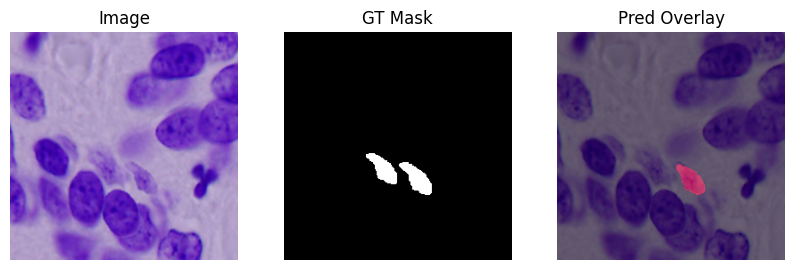

Inference:   0%|                                                  | 0/257 [00:01<?, ?it/s, last_idx=1, last_dice=0.9337]

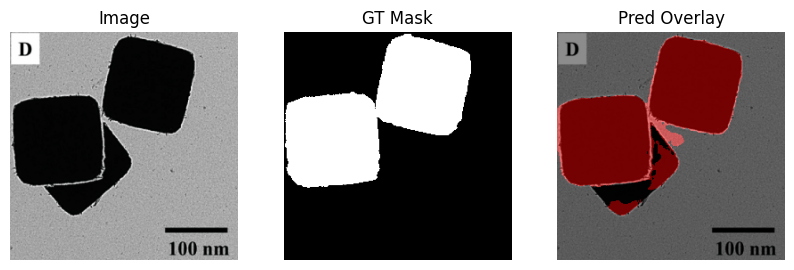

Inference:   0%|                                                  | 0/257 [00:01<?, ?it/s, last_idx=2, last_dice=0.6590]

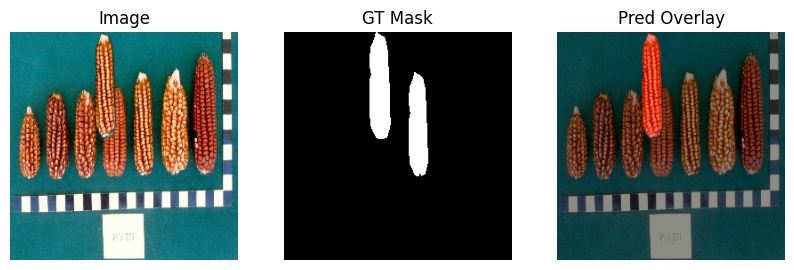

Inference:   0%|                                                  | 0/257 [00:01<?, ?it/s, last_idx=3, last_dice=0.5181]

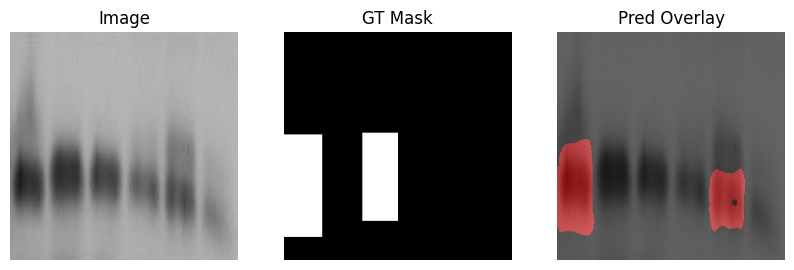

Inference:   0%|▏                                          | 1/257 [00:01<06:35,  1.55s/it, last_idx=4, last_dice=no-gt]

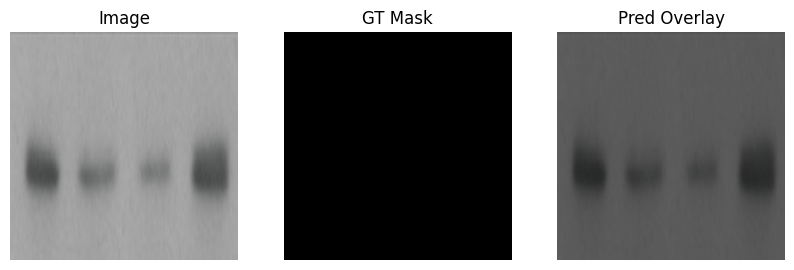

Inference:   0%|▏                                          | 1/257 [00:01<06:35,  1.55s/it, last_idx=5, last_dice=no-gt]

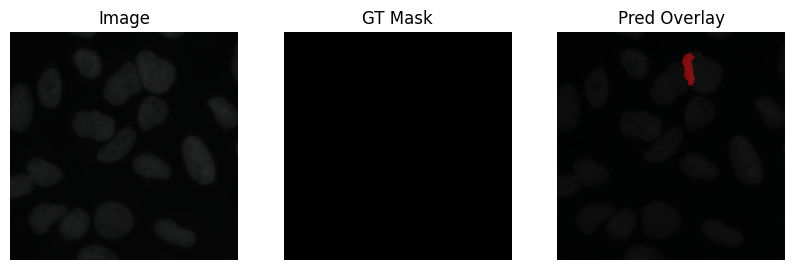

Inference: 100%|█████████████████████████████████████| 257/257 [00:45<00:00,  5.59it/s, last_idx=1025, last_dice=0.5641]


Saved visualizations to: inference_results
Images with GT masks: 549 | Mean Dice (for those): 0.517869
Elapsed: 0.7771359920501709 min


In [6]:
# inference_visualization_full.py
"""
Inference + Visualization for HybridForgeryModel (Windows-friendly)

Saves:
 - ./inference_results/vis_{i}.png   (overlay visualization)
 - ./inference_results/pred_mask_{i}.png  (binary mask)
 - prints per-image Dice and mean Dice (for images with GT masks)
"""

import os
import glob
import time
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

# ---------------- CONFIG ----------------
ROOT = r"d:/Image_forgery_detection/Data"
MODEL_PATH = "best_hybrid_windows_fix.pth"
IMG_SIZE = 256
BATCH_SIZE = 4
NUM_WORKERS = 0
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
THR = 0.5
SAVE_DIR = "inference_results"
NUM_DISPLAY = 6    # number of examples to plot inline (if running in notebook)

os.makedirs(SAVE_DIR, exist_ok=True)
print("DEVICE:", DEVICE, "torch:", torch.__version__)

# ---------------- Model class (same structure as training: uses smp.Unet encoder + classifier) ----------------
import segmentation_models_pytorch as smp

class HybridForgeryModel(nn.Module):
    def __init__(self, encoder_name="efficientnet-b0", pretrained=True):
        super().__init__()
        try:
            self.seg_model = smp.Unet(
                encoder_name=encoder_name,
                encoder_weights="imagenet" if pretrained else None,
                in_channels=3,
                classes=1
            )
        except Exception as e:
            print("Encoder load failed:", e)
            # fallback
            self.seg_model = smp.Unet(
                encoder_name="efficientnet-b0",
                encoder_weights="imagenet" if pretrained else None,
                in_channels=3,
                classes=1
            )
        enc_chs = self.seg_model.encoder.out_channels
        bottleneck = enc_chs[-1]
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(bottleneck, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        enc_feats = self.seg_model.encoder(x)          # list of feature maps
        deep = enc_feats[-1]
        cls_logit = self.classifier(deep)
        dec = self.seg_model.decoder(enc_feats)       # pass list, not unpack
        seg = self.seg_model.segmentation_head(dec)
        return seg, cls_logit

# ---------------- Build file lists (same logic as training) ----------------
auth_dir = os.path.join(ROOT, "train_images", "authentic")
forg_dir = os.path.join(ROOT, "train_images", "forged")
mask_dir = os.path.join(ROOT, "train_masks")

assert os.path.exists(auth_dir), f"{auth_dir} not found"
assert os.path.exists(forg_dir), f"{forg_dir} not found"
assert os.path.exists(mask_dir), f"{mask_dir} not found"

auth_imgs = sorted(glob.glob(os.path.join(auth_dir, "*.png")))
forg_imgs = sorted(glob.glob(os.path.join(forg_dir, "*.png")))
mask_files = sorted(glob.glob(os.path.join(mask_dir, "*.npy")))
mask_dict = { os.path.basename(p).rsplit(".",1)[0] : p for p in mask_files }

items = []
for p in auth_imgs:
    items.append((p, None, 0))
for p in forg_imgs:
    base = os.path.basename(p).rsplit(".",1)[0]
    m = mask_dict.get(base, None)
    items.append((p, m, 1))

print("TOTAL images:", len(items),
      "masks(found):", sum(1 for it in items if it[1] is not None))

# ---------------- Create the same train/val split used in training ----------------
img_paths = [it[0] for it in items]
mask_paths = [it[1] for it in items]
labels = [it[2] for it in items]

# Use the same split fraction and random seed as training (80/20)
train_imgs, val_imgs, train_masks, val_masks, train_labels, val_labels = train_test_split(
    img_paths, mask_paths, labels, test_size=0.2, stratify=labels, random_state=42
)

print("Validation samples:", len(val_imgs))

# ---------------- Inference Dataset ----------------
class InferenceDataset(Dataset):
    def __init__(self, image_paths, mask_paths, image_size=IMG_SIZE):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.tf = A.Compose([
            A.Resize(image_size, image_size),
            A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
            ToTensorV2()
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        p = self.image_paths[idx]
        img = cv2.imread(p, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        mpath = self.mask_paths[idx]
        if mpath is not None and os.path.exists(mpath):
            mask = np.load(mpath)
            if mask.ndim == 3:
                mask = mask[0]
            mask = (mask > 0).astype("uint8")
        else:
            mask = np.zeros((img.shape[0], img.shape[1]), dtype="uint8")

        augmented = self.tf(image=img, mask=mask)
        img_t = augmented["image"]              # torch tensor (C,H,W) float, normalized
        mask_t = augmented["mask"].unsqueeze(0).float()  # (1,H,W)
        return img_t, mask_t, p

# ---------------- Load model (handles full checkpoint with "model_state") ----------------
def load_model(model_path, device):
    ckpt = torch.load(model_path, map_location=device)
    if isinstance(ckpt, dict) and "model_state" in ckpt:
        state = ckpt["model_state"]
        print("Checkpoint contains 'model_state'. Using that entry.")
    else:
        state = ckpt
        print("Loaded raw state_dict (no 'model_state' key).")

    model = HybridForgeryModel(encoder_name="efficientnet-b0", pretrained=True)
    model.load_state_dict(state)
    model = model.to(device)
    model.eval()
    return model

# ---------------- Metric helpers ----------------
def dice_np(pred_mask, gt_mask, eps=1e-6):
    p = (pred_mask > 0.5).astype(np.uint8)
    g = (gt_mask > 0.5).astype(np.uint8)
    inter = (p & g).sum()
    union = p.sum() + g.sum()
    return (2 * inter + eps) / (union + eps)

def overlay_on_image(rgb_img, mask_bin, color=(255,0,0), alpha=0.5):
    # rgb_img: HxWx3 (0..255), mask_bin: HxW {0,255}
    color_map = np.zeros_like(rgb_img)
    color_map[..., 0] = mask_bin  # red channel
    over = cv2.addWeighted(rgb_img.astype(np.uint8), 1.0 - alpha, color_map.astype(np.uint8), alpha, 0)
    return over

# ---------------- Run inference ----------------
def run_inference():
    ds = InferenceDataset(val_imgs, val_masks, image_size=IMG_SIZE)
    loader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

    model = load_model(MODEL_PATH, DEVICE)
    total_dice = []
    count_with_gt = 0

    pbar = tqdm(loader, desc="Inference", ncols=120)
    idx = 0
    for imgs, masks, paths in pbar:
        imgs = imgs.to(DEVICE)
        with torch.no_grad():
            # autocast is optional for inference; using torch.autocast can save memory/time on GPU
            # Using plain no grad and FP32 is fine
            seg_logits, cls_logits = model(imgs)
            seg_probs = torch.sigmoid(seg_logits).cpu().numpy()  # (B,1,H,W)

        imgs_np = imgs.cpu().numpy()
        masks_np = masks.cpu().numpy()  # (B,1,H,W)

        B = seg_probs.shape[0]
        for b in range(B):
            prob = seg_probs[b,0]
            pred_bin = (prob > THR).astype(np.uint8) * 255

            # Recover original RGB image (from normalized tensor)
            img_t = imgs_np[b]  # (C,H,W)
            # un-normalize
            mean = np.array([0.485,0.456,0.406])[:,None,None]
            std  = np.array([0.229,0.224,0.225])[:,None,None]
            img_unnorm = (img_t * std + mean) * 255.0
            img_unnorm = np.clip(img_unnorm.transpose(1,2,0), 0, 255).astype(np.uint8)

            # Save predicted mask png
            out_mask_path = os.path.join(SAVE_DIR, f"pred_mask_{idx}.png")
            cv2.imwrite(out_mask_path, pred_bin)

            # overlay
            overlay = overlay_on_image(img_unnorm, pred_bin, color=(255,0,0), alpha=0.45)
            out_vis_path = os.path.join(SAVE_DIR, f"vis_{idx}.png")
            cv2.imwrite(out_vis_path, cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))

            # compute dice if GT available
            gt = masks_np[b,0]
            if gt.sum() > 0:
                dice_val = dice_np(prob, gt)
                total_dice.append(dice_val)
                count_with_gt += 1
            else:
                # if no gt pixels, skip dice stats (or treat separately)
                dice_val = None

            pbar.set_postfix({"last_idx": idx, "last_dice": f"{dice_val:.4f}" if dice_val is not None else "no-gt"})

            if idx < NUM_DISPLAY:
                # show small preview inline if running in notebook
                try:
                    import matplotlib.pyplot as plt
                    plt.figure(figsize=(10,3))
                    plt.subplot(1,3,1); plt.title("Image"); plt.imshow(img_unnorm); plt.axis("off")
                    plt.subplot(1,3,2); plt.title("GT Mask"); 
                    plt.imshow(gt, cmap="gray"); plt.axis("off")
                    plt.subplot(1,3,3); plt.title("Pred Overlay"); 
                    plt.imshow(overlay); plt.axis("off")
                    plt.show()
                except Exception:
                    pass

            idx += 1

    mean_dice = np.mean(total_dice) if total_dice else float("nan")
    print(f"\nSaved visualizations to: {SAVE_DIR}")
    print(f"Images with GT masks: {count_with_gt} | Mean Dice (for those): {mean_dice:.6f}")

if __name__ == "__main__":
    t0 = time.time()
    run_inference()
    print("Elapsed:", (time.time()-t0)/60, "min")


Total forged images: 2751

=== Checking 10 random forged samples ===

3958.png: Mask binary=True, Unique vals=[  0 255]


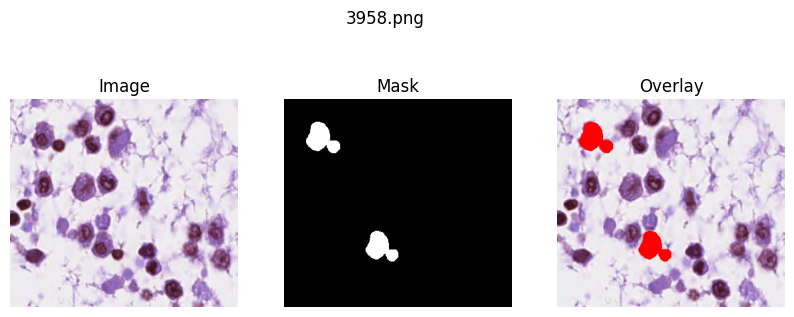

62733.png: Mask binary=True, Unique vals=[  0 255]


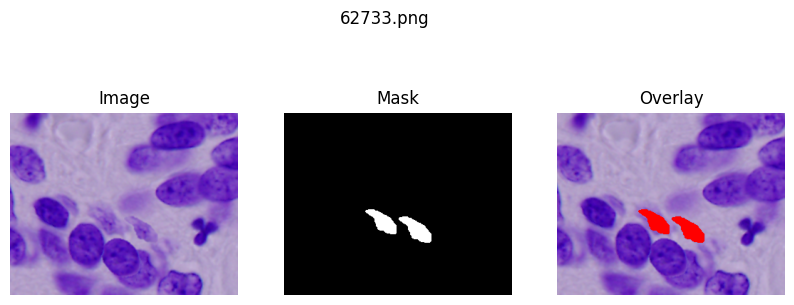

32934.png: Mask binary=True, Unique vals=[  0 255]


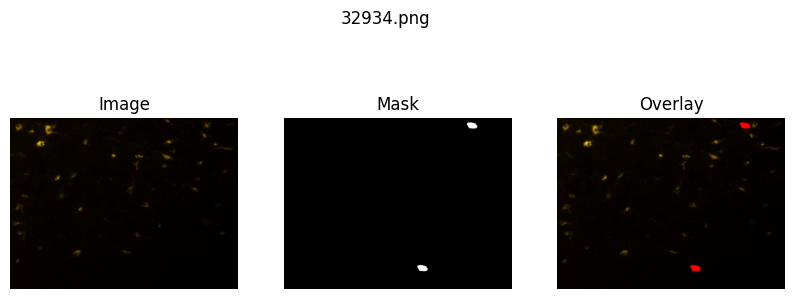

13624.png: Mask binary=True, Unique vals=[  0 255]


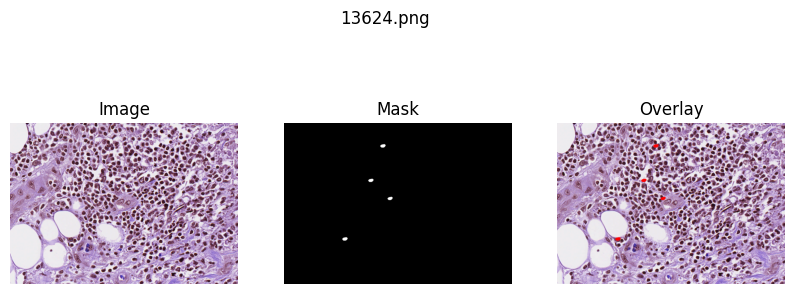

49711.png: Mask binary=True, Unique vals=[  0 255]


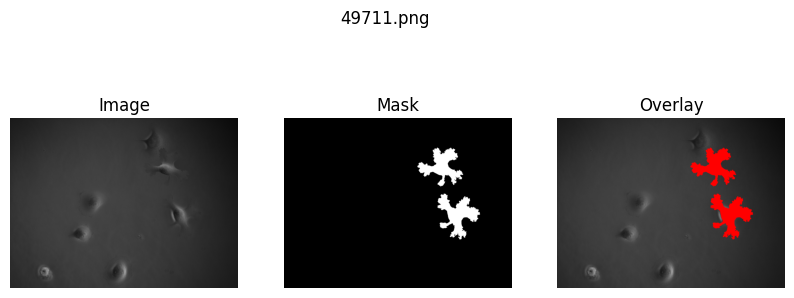

56339.png: Mask binary=True, Unique vals=[  0 255]


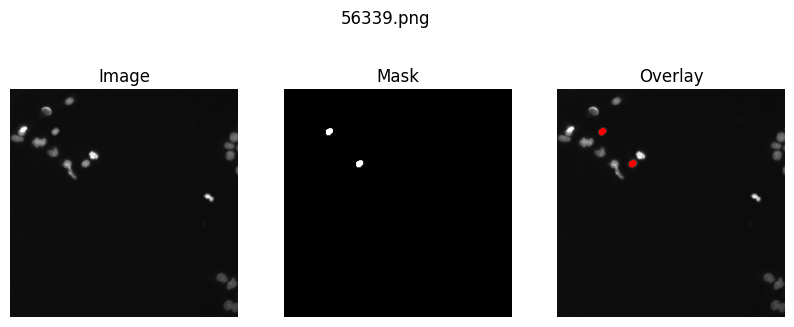

20736.png: Mask binary=True, Unique vals=[  0 255]


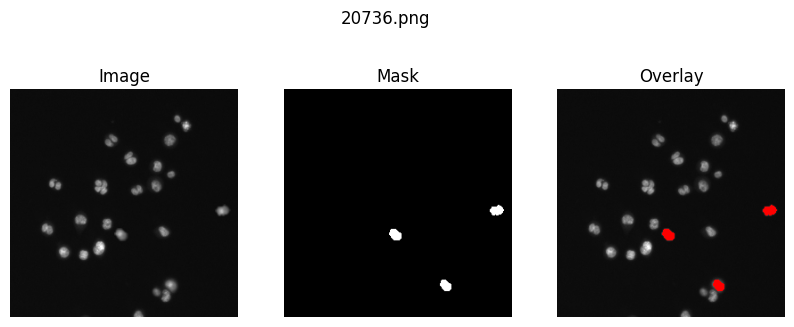

4222.png: Mask binary=True, Unique vals=[  0 255]


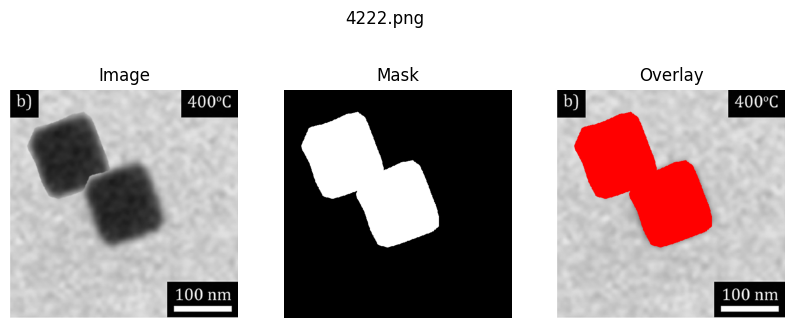

16227.png: Mask binary=True, Unique vals=[  0 255]


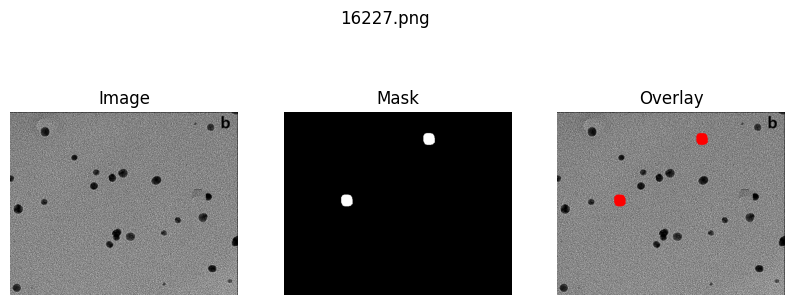

57729.png: Mask binary=True, Unique vals=[  0 255]


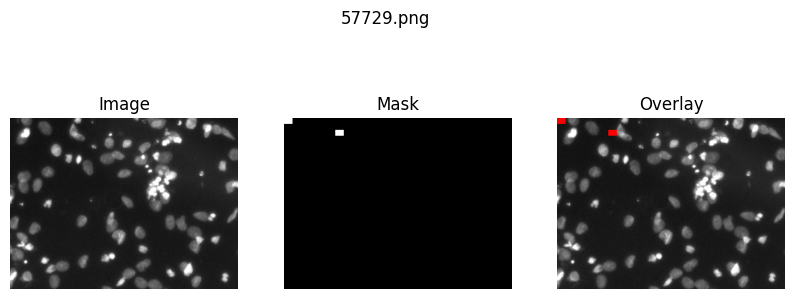

In [18]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------------------
# CONFIG: UPDATE THESE
# ----------------------------------------
IMAGE_DIR = r"d:\Image_forgery_detection\Data\train_images\forged"
MASK_DIR  = r"d:\Image_forgery_detection\Data\train_masks"
MASK_EXT = ".npy"   # <<<<<< CORRECT EXTENSION

# ----------------------------------------
# UTILS
# ----------------------------------------
def is_binary_mask(mask):
    unique_vals = np.unique(mask)
    return set(unique_vals.tolist()).issubset({0, 255}), unique_vals

def show_pair(img, mask, title=""):
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(img[:, :, ::-1])
    plt.title("Image"); plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap="gray")
    plt.title("Mask"); plt.axis("off")

    plt.subplot(1, 3, 3)
    overlay = img.copy()
    overlay[mask > 0] = [0, 0, 255]
    plt.imshow(overlay[:, :, ::-1])
    plt.title("Overlay"); plt.axis("off")

    plt.suptitle(title)
    plt.show()

# ----------------------------------------
# MAIN CHECK
# ----------------------------------------

images = [f for f in os.listdir(IMAGE_DIR)
          if f.lower().endswith((".jpg", ".png", ".jpeg"))]

print(f"Total forged images: {len(images)}\n")

sample = random.sample(images, min(10, len(images)))

print("=== Checking 10 random forged samples ===\n")

for img_name in sample:
    base = os.path.splitext(img_name)[0]
    mask_path = os.path.join(MASK_DIR, base + MASK_EXT)

    if not os.path.exists(mask_path):
        print(f"[MISSING MASK] {mask_path}")
        continue

    img = cv2.imread(os.path.join(IMAGE_DIR, img_name))

    mask = np.load(mask_path)
    if mask.ndim == 3:
        mask = mask[0]
    mask = (mask > 0).astype("uint8") * 255

    is_bin, unique_vals = is_binary_mask(mask)
    print(f"{img_name}: Mask binary={is_bin}, Unique vals={unique_vals}")

    show_pair(img, mask, title=img_name)


In [2]:
# train_hybrid_stepB.py
"""
HybridForgeryModel Training - Step B
Windows-friendly
Improvements for better accuracy:
- Proper mask handling
- Stratified split
- Albumentations augmentation
- AMP (autocast) + gradient clipping
- Checkpoint saving
"""

import os
import glob
import random
import time
import numpy as np
import cv2
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast, GradScaler
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp

# ---------------- CONFIG ----------------
ROOT = r"d:/Image_forgery_detection/Data"
IMG_SIZE = 256
BATCH_SIZE = 8
NUM_WORKERS = 0      # Windows-safe
EPOCHS = 25
LR = 1e-4
SEED = 42
ENCODER = "efficientnet-b0"
PRETRAINED = True
SAVE_PATH = "best_hybrid_stepB.pth"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CLIP_GRAD_NORM = 5.0

# reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

print("DEVICE:", DEVICE, "torch:", torch.__version__)

# ---------------- Utility: list images ----------------
def list_images(folder):
    exts = ["*.png", "*.jpg", "*.jpeg", "*.PNG", "*.JPG", "*.JPEG"]
    files = []
    for e in exts:
        files.extend(glob.glob(os.path.join(folder, e)))
    return sorted(files)

# ---------------- Build dataset ----------------
auth_dir = os.path.join(ROOT, "train_images", "authentic")
forg_dir = os.path.join(ROOT, "train_images", "forged")
mask_dir = os.path.join(ROOT, "train_masks")

assert os.path.exists(auth_dir)
assert os.path.exists(forg_dir)
assert os.path.exists(mask_dir)

auth_list = list_images(auth_dir)
forg_list = list_images(forg_dir)
mask_list = glob.glob(os.path.join(mask_dir, "*.npy"))
mask_dict = {os.path.basename(p).rsplit(".",1)[0]: p for p in mask_list}

items = []
for p in auth_list:
    items.append((p, None, 0))
for p in forg_list:
    base = os.path.basename(p).rsplit(".",1)[0]
    m = mask_dict.get(base, None)
    if m is None:
        print("WARN: missing mask for", base)
    items.append((p, m, 1))

print(f"TOTAL images: {len(items)}, masks found: {sum(1 for it in items if it[1] is not None)}")

# ---------------- Split ----------------
img_paths = [it[0] for it in items]
mask_paths = [it[1] for it in items]
labels = [it[2] for it in items]

train_imgs, val_imgs, train_masks, val_masks, train_labels, val_labels = train_test_split(
    img_paths, mask_paths, labels, test_size=0.2, stratify=labels, random_state=SEED
)

print("Train/Val:", len(train_imgs), "/", len(val_imgs))
print("Train forged ratio:", sum(train_labels)/len(train_labels))

# ---------------- Dataset ----------------
class ForgeryDataset(Dataset):
    def __init__(self, image_paths, mask_paths, labels, transform=None, size=(IMG_SIZE, IMG_SIZE)):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.labels = labels
        self.transform = transform
        self.size = size

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.image_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, self.size, interpolation=cv2.INTER_AREA)

        mask_path = self.mask_paths[idx]
        if mask_path is not None:
            mask = np.load(mask_path)
            if mask.ndim == 3: mask = mask[0]
            mask = cv2.resize(mask, self.size, interpolation=cv2.INTER_NEAREST)
            mask = (mask > 0).astype("uint8")
        else:
            mask = np.zeros(self.size, dtype="uint8")

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented["image"]
            mask = augmented["mask"]
            if isinstance(mask, np.ndarray):
                mask = torch.from_numpy(mask).unsqueeze(0).float()
            elif mask.ndim == 2:
                mask = mask.unsqueeze(0).float()
            else:
                mask = mask.float()
        else:
            img = torch.from_numpy(img).permute(2,0,1).float()/255.0
            mask = torch.from_numpy(mask).unsqueeze(0).float()

        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return img, mask, label

# ---------------- Transforms ----------------
train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.06, scale_limit=0.08, rotate_limit=18, p=0.5),
    A.RandomBrightnessContrast(p=0.4),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2(),
])

# ---------------- Dataloaders ----------------
train_ds = ForgeryDataset(train_imgs, train_masks, train_labels, transform=train_transform)
val_ds = ForgeryDataset(val_imgs, val_masks, val_labels, transform=val_transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=NUM_WORKERS, pin_memory=True)

print("Train batches:", len(train_loader), "Val batches:", len(val_loader))

# ---------------- Model ----------------
class HybridForgeryModel(nn.Module):
    def __init__(self, encoder_name=ENCODER, pretrained=PRETRAINED):
        super().__init__()
        self.seg_model = smp.Unet(
            encoder_name=encoder_name,
            encoder_weights="imagenet" if pretrained else None,
            in_channels=3,
            classes=1
        )
        bottleneck = self.seg_model.encoder.out_channels[-1]
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(bottleneck, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        enc_feats = self.seg_model.encoder(x)
        deep = enc_feats[-1]
        cls_logit = self.classifier(deep)
        dec = self.seg_model.decoder(enc_feats)
        seg = self.seg_model.segmentation_head(dec)
        return seg, cls_logit

model = HybridForgeryModel().to(DEVICE)
print("Model params (M):", sum(p.numel() for p in model.parameters())/1e6)

# ---------------- Loss, optimizer, AMP ----------------
bce_cls = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-5)
scaler = GradScaler()

def dice_loss_from_logits(logits, target, eps=1e-6):
    pred = torch.sigmoid(logits)
    inter = (pred*target).sum(dim=(2,3))
    denom = pred.sum(dim=(2,3)) + target.sum(dim=(2,3))
    dice = (2*inter + eps)/(denom+eps)
    return 1 - dice.mean()

def combo_seg_loss(logits, target, bce_w=0.5, dice_w=0.5):
    target = target.float()
    bce = F.binary_cross_entropy_with_logits(logits, target)
    d_loss = dice_loss_from_logits(logits, target)
    return bce_w*bce + dice_w*d_loss, bce.item(), d_loss.item()

def dice_metric(pred_logits, target, thr=0.5, eps=1e-6):
    pred = (torch.sigmoid(pred_logits) > thr).float()
    inter = (pred*target).sum(dim=(1,2,3))
    union = pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3))
    dice = (2*inter+eps)/(union+eps)
    return dice.mean().item()

# ---------------- Train / Val loops ----------------
def train_one_epoch(epoch):
    model.train()
    losses, dices = [], []
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} [Train]", ncols=120)
    for imgs, masks, labels in pbar:
        imgs, masks, labels = imgs.to(DEVICE), masks.to(DEVICE), labels.to(DEVICE).unsqueeze(1)
        optimizer.zero_grad()
        with autocast(device_type="cuda"):
            seg_logits, cls_logits = model(imgs)
            seg_loss, _, _ = combo_seg_loss(seg_logits, masks)
            cls_loss = bce_cls(cls_logits, labels)
            loss = seg_loss + 0.3*cls_loss

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_GRAD_NORM)
        scaler.step(optimizer)
        scaler.update()

        losses.append(loss.item())
        dices.append(dice_metric(seg_logits, masks))
        pbar.set_postfix({"loss": f"{np.mean(losses):.4f}", "dice": f"{np.mean(dices):.4f}"})
    return np.mean(losses), np.mean(dices)

def validate(epoch):
    model.eval()
    losses, dices = [], []
    with torch.no_grad():
        pbar = tqdm(val_loader, desc=f"Epoch {epoch}/{EPOCHS} [Val]", ncols=120)
        for imgs, masks, labels in pbar:
            imgs, masks, labels = imgs.to(DEVICE), masks.to(DEVICE), labels.to(DEVICE).unsqueeze(1)
            seg_logits, cls_logits = model(imgs)
            seg_loss, _, _ = combo_seg_loss(seg_logits, masks)
            cls_loss = bce_cls(cls_logits, labels)
            loss = seg_loss + 0.3*cls_loss

            losses.append(loss.item())
            dices.append(dice_metric(seg_logits, masks))
            pbar.set_postfix({"val_loss": f"{np.mean(losses):.4f}", "val_dice": f"{np.mean(dices):.4f}"})
    return np.mean(losses), np.mean(dices)

# ---------------- MAIN ----------------
if __name__ == "__main__":
    best_val_dice = -1.0
    for epoch in range(1, EPOCHS+1):
        t0 = time.time()
        train_loss, train_dice = train_one_epoch(epoch)
        val_loss, val_dice = validate(epoch)
        print(f"\nEpoch {epoch} time: {(time.time()-t0)/60:.2f} min")
        print(f"Train loss: {train_loss:.4f} | Train dice: {train_dice:.4f}")
        print(f"Val loss: {val_loss:.4f} | Val dice: {val_dice:.4f}")

        if val_dice > best_val_dice:
            best_val_dice = val_dice
            torch.save({
                "epoch": epoch,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "best_val_dice": best_val_dice
            }, SAVE_PATH)
            print("Saved best model ->", SAVE_PATH)

    print("Training complete. Best Val Dice:", best_val_dice)


d:\Image_forgery_detection\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DEVICE: cuda torch: 2.5.1+cu121
TOTAL images: 10256, masks found: 5502
Train/Val: 8204 / 2052
Train forged ratio: 0.5364456362749878
Train batches: 1026 Val batches: 257


d:\Image_forgery_detection\venv\lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Model params (M): 6.333902


Epoch 1/25 [Val]: 100%|█████████████████████████████| 257/257 [01:01<00:00,  4.17it/s, val_loss=0.6818, val_dice=0.3121]



Epoch 1 time: 6.28 min
Train loss: 0.7807 | Train dice: 0.1629
Val loss: 0.6818 | Val dice: 0.3121
Saved best model -> best_hybrid_stepB.pth


Epoch 2/25 [Val]: 100%|█████████████████████████████| 257/257 [01:01<00:00,  4.15it/s, val_loss=0.5982, val_dice=0.3441]



Epoch 2 time: 6.25 min
Train loss: 0.6535 | Train dice: 0.2671
Val loss: 0.5982 | Val dice: 0.3441
Saved best model -> best_hybrid_stepB.pth


Epoch 3/25 [Val]: 100%|█████████████████████████████| 257/257 [01:01<00:00,  4.17it/s, val_loss=0.5838, val_dice=0.3747]



Epoch 3 time: 6.22 min
Train loss: 0.6094 | Train dice: 0.3101
Val loss: 0.5838 | Val dice: 0.3747
Saved best model -> best_hybrid_stepB.pth


Epoch 4/25 [Val]: 100%|█████████████████████████████| 257/257 [01:01<00:00,  4.19it/s, val_loss=0.5588, val_dice=0.3980]



Epoch 4 time: 6.21 min
Train loss: 0.5930 | Train dice: 0.3297
Val loss: 0.5588 | Val dice: 0.3980
Saved best model -> best_hybrid_stepB.pth


Epoch 5/25 [Val]: 100%|█████████████████████████████| 257/257 [01:01<00:00,  4.18it/s, val_loss=0.5569, val_dice=0.4081]



Epoch 5 time: 6.20 min
Train loss: 0.5757 | Train dice: 0.3465
Val loss: 0.5569 | Val dice: 0.4081
Saved best model -> best_hybrid_stepB.pth


Epoch 6/25 [Val]: 100%|█████████████████████████████| 257/257 [01:00<00:00,  4.23it/s, val_loss=0.5515, val_dice=0.4506]



Epoch 6 time: 6.19 min
Train loss: 0.5683 | Train dice: 0.3556
Val loss: 0.5515 | Val dice: 0.4506
Saved best model -> best_hybrid_stepB.pth


Epoch 7/25 [Val]: 100%|█████████████████████████████| 257/257 [01:01<00:00,  4.20it/s, val_loss=0.5427, val_dice=0.4013]



Epoch 7 time: 6.20 min
Train loss: 0.5576 | Train dice: 0.3735
Val loss: 0.5427 | Val dice: 0.4013


Epoch 8/25 [Val]: 100%|█████████████████████████████| 257/257 [01:01<00:00,  4.15it/s, val_loss=0.5357, val_dice=0.4613]



Epoch 8 time: 6.21 min
Train loss: 0.5502 | Train dice: 0.3678
Val loss: 0.5357 | Val dice: 0.4613
Saved best model -> best_hybrid_stepB.pth


Epoch 9/25 [Val]: 100%|█████████████████████████████| 257/257 [01:01<00:00,  4.19it/s, val_loss=0.5381, val_dice=0.4186]



Epoch 9 time: 6.21 min
Train loss: 0.5435 | Train dice: 0.3892
Val loss: 0.5381 | Val dice: 0.4186


Epoch 10/25 [Val]: 100%|████████████████████████████| 257/257 [01:01<00:00,  4.18it/s, val_loss=0.5301, val_dice=0.4515]



Epoch 10 time: 6.19 min
Train loss: 0.5361 | Train dice: 0.4006
Val loss: 0.5301 | Val dice: 0.4515


Epoch 11/25 [Val]: 100%|████████████████████████████| 257/257 [01:01<00:00,  4.18it/s, val_loss=0.5248, val_dice=0.4476]



Epoch 11 time: 6.22 min
Train loss: 0.5290 | Train dice: 0.4040
Val loss: 0.5248 | Val dice: 0.4476


Epoch 12/25 [Val]: 100%|████████████████████████████| 257/257 [01:01<00:00,  4.20it/s, val_loss=0.5228, val_dice=0.4547]



Epoch 12 time: 6.23 min
Train loss: 0.5229 | Train dice: 0.4037
Val loss: 0.5228 | Val dice: 0.4547


Epoch 13/25 [Val]: 100%|████████████████████████████| 257/257 [01:01<00:00,  4.17it/s, val_loss=0.5152, val_dice=0.4522]



Epoch 13 time: 6.20 min
Train loss: 0.5200 | Train dice: 0.4166
Val loss: 0.5152 | Val dice: 0.4522


Epoch 14/25 [Val]: 100%|████████████████████████████| 257/257 [01:01<00:00,  4.19it/s, val_loss=0.5068, val_dice=0.4509]



Epoch 14 time: 6.20 min
Train loss: 0.5131 | Train dice: 0.4427
Val loss: 0.5068 | Val dice: 0.4509


Epoch 15/25 [Val]: 100%|████████████████████████████| 257/257 [01:00<00:00,  4.25it/s, val_loss=0.5073, val_dice=0.5104]



Epoch 15 time: 6.18 min
Train loss: 0.5081 | Train dice: 0.4387
Val loss: 0.5073 | Val dice: 0.5104
Saved best model -> best_hybrid_stepB.pth


Epoch 16/25 [Val]: 100%|████████████████████████████| 257/257 [01:00<00:00,  4.23it/s, val_loss=0.5035, val_dice=0.4593]



Epoch 16 time: 6.22 min
Train loss: 0.5068 | Train dice: 0.4493
Val loss: 0.5035 | Val dice: 0.4593


Epoch 17/25 [Val]: 100%|████████████████████████████| 257/257 [01:00<00:00,  4.22it/s, val_loss=0.5023, val_dice=0.4752]



Epoch 17 time: 6.17 min
Train loss: 0.4999 | Train dice: 0.4600
Val loss: 0.5023 | Val dice: 0.4752


Epoch 18/25 [Val]: 100%|████████████████████████████| 257/257 [01:00<00:00,  4.22it/s, val_loss=0.5037, val_dice=0.5225]



Epoch 18 time: 6.20 min
Train loss: 0.4970 | Train dice: 0.4687
Val loss: 0.5037 | Val dice: 0.5225
Saved best model -> best_hybrid_stepB.pth


Epoch 19/25 [Val]: 100%|████████████████████████████| 257/257 [01:01<00:00,  4.21it/s, val_loss=0.5117, val_dice=0.4998]



Epoch 19 time: 6.20 min
Train loss: 0.4931 | Train dice: 0.4723
Val loss: 0.5117 | Val dice: 0.4998


Epoch 20/25 [Val]: 100%|████████████████████████████| 257/257 [01:00<00:00,  4.24it/s, val_loss=0.5062, val_dice=0.5486]



Epoch 20 time: 6.18 min
Train loss: 0.4863 | Train dice: 0.4881
Val loss: 0.5062 | Val dice: 0.5486
Saved best model -> best_hybrid_stepB.pth


Epoch 21/25 [Val]: 100%|████████████████████████████| 257/257 [01:01<00:00,  4.19it/s, val_loss=0.5086, val_dice=0.5318]



Epoch 21 time: 6.28 min
Train loss: 0.4842 | Train dice: 0.4955
Val loss: 0.5086 | Val dice: 0.5318


Epoch 22/25 [Val]: 100%|████████████████████████████| 257/257 [01:03<00:00,  4.08it/s, val_loss=0.5053, val_dice=0.4904]



Epoch 22 time: 6.26 min
Train loss: 0.4804 | Train dice: 0.4929
Val loss: 0.5053 | Val dice: 0.4904


Epoch 23/25 [Val]: 100%|████████████████████████████| 257/257 [01:06<00:00,  3.84it/s, val_loss=0.5032, val_dice=0.5431]



Epoch 23 time: 6.55 min
Train loss: 0.4797 | Train dice: 0.4946
Val loss: 0.5032 | Val dice: 0.5431


Epoch 24/25 [Val]: 100%|████████████████████████████| 257/257 [01:04<00:00,  3.97it/s, val_loss=0.5018, val_dice=0.4748]



Epoch 24 time: 6.39 min
Train loss: 0.4753 | Train dice: 0.4908
Val loss: 0.5018 | Val dice: 0.4748


Epoch 25/25 [Val]: 100%|████████████████████████████| 257/257 [01:01<00:00,  4.16it/s, val_loss=0.5041, val_dice=0.5378]


Epoch 25 time: 6.36 min
Train loss: 0.4727 | Train dice: 0.5002
Val loss: 0.5041 | Val dice: 0.5378
Training complete. Best Val Dice: 0.5486125648021698


In [2]:
# train_hybrid_stepB_v2.py
"""
HybridForgeryModel Training - Step B (Improved for small masks)
Features:
- High-res input
- Tversky + Dice loss
- Stronger augmentation
- Per-pixel weighting
- Deeper encoder
- Cosine LR scheduler
"""

import os, glob, random, time
import numpy as np
import cv2
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast, GradScaler
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp

# ---------------- CONFIG ----------------
ROOT = r"d:/Image_forgery_detection/Data"
IMG_SIZE = 384          # higher resolution
BATCH_SIZE = 8
NUM_WORKERS = 0         # Windows safe
EPOCHS = 25
LR = 1e-4
SEED = 42
ENCODER = "efficientnet-b3"
PRETRAINED = True
SAVE_PATH = "best_hybrid_stepB_v2.pth"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CLIP_GRAD_NORM = 5.0

# reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

print("DEVICE:", DEVICE, "torch:", torch.__version__)

# ---------------- Utility ----------------
def list_images(folder):
    exts = ["*.png", "*.jpg", "*.jpeg", "*.PNG", "*.JPG", "*.JPEG"]
    files = []
    for e in exts:
        files.extend(glob.glob(os.path.join(folder, e)))
    return sorted(files)

# ---------------- Dataset ----------------
auth_dir = os.path.join(ROOT, "train_images", "authentic")
forg_dir = os.path.join(ROOT, "train_images", "forged")
mask_dir = os.path.join(ROOT, "train_masks")

auth_list = list_images(auth_dir)
forg_list = list_images(forg_dir)
mask_list = glob.glob(os.path.join(mask_dir, "*.npy"))
mask_dict = {os.path.basename(p).rsplit(".",1)[0]: p for p in mask_list}

items = []
for p in auth_list:
    items.append((p, None, 0))
for p in forg_list:
    base = os.path.basename(p).rsplit(".",1)[0]
    m = mask_dict.get(base, None)
    if m is None:
        print("WARN: missing mask for", base)
    items.append((p, m, 1))

img_paths = [it[0] for it in items]
mask_paths = [it[1] for it in items]
labels = [it[2] for it in items]

train_imgs, val_imgs, train_masks, val_masks, train_labels, val_labels = train_test_split(
    img_paths, mask_paths, labels, test_size=0.2, stratify=labels, random_state=SEED
)

print("Train/Val:", len(train_imgs), "/", len(val_imgs))
print("Train forged ratio:", sum(train_labels)/len(train_labels))

# ---------------- Dataset Class ----------------
class ForgeryDataset(Dataset):
    def __init__(self, image_paths, mask_paths, labels, transform=None, size=(IMG_SIZE, IMG_SIZE)):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.labels = labels
        self.transform = transform
        self.size = size

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.image_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, self.size, interpolation=cv2.INTER_AREA)

        mask_path = self.mask_paths[idx]
        if mask_path is not None:
            mask = np.load(mask_path)
            if mask.ndim == 3: mask = mask[0]
            mask = cv2.resize(mask, self.size, interpolation=cv2.INTER_NEAREST)
            mask = (mask > 0).astype("float32")
        else:
            mask = np.zeros(self.size, dtype="float32")

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented["image"]
            mask = augmented["mask"].unsqueeze(0).float()
        else:
            img = torch.from_numpy(img).permute(2,0,1).float()/255.0
            mask = torch.from_numpy(mask).unsqueeze(0).float()

        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return img, mask, label

# ---------------- Transforms ----------------
train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.06, scale_limit=0.08, rotate_limit=18, p=0.5),
    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=10, p=0.3),
    A.GridDistortion(p=0.3),
    A.RandomBrightnessContrast(p=0.4),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2(),
])

train_ds = ForgeryDataset(train_imgs, train_masks, train_labels, transform=train_transform)
val_ds = ForgeryDataset(val_imgs, val_masks, val_labels, transform=val_transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=NUM_WORKERS, pin_memory=True)

print("Train batches:", len(train_loader), "Val batches:", len(val_loader))

# ---------------- Model ----------------
class HybridForgeryModel(nn.Module):
    def __init__(self, encoder_name=ENCODER, pretrained=PRETRAINED):
        super().__init__()
        self.seg_model = smp.Unet(
            encoder_name=encoder_name,
            encoder_weights="imagenet" if pretrained else None,
            in_channels=3,
            classes=1
        )
        bottleneck = self.seg_model.encoder.out_channels[-1]
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(bottleneck, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        enc_feats = self.seg_model.encoder(x)
        deep = enc_feats[-1]
        cls_logit = self.classifier(deep)
        dec = self.seg_model.decoder(enc_feats)
        seg = self.seg_model.segmentation_head(dec)
        return seg, cls_logit

model = HybridForgeryModel().to(DEVICE)
print("Model params (M):", sum(p.numel() for p in model.parameters())/1e6)

# ---------------- Loss & Optimizer ----------------
bce_cls = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-5)
scaler = GradScaler()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

# Dice + Tversky for small masks
def tversky_loss(logits, target, alpha=0.7, beta=0.3, eps=1e-6):
    pred = torch.sigmoid(logits)
    TP = (pred * target).sum(dim=(2,3))
    FP = ((1-pred) * target).sum(dim=(2,3))
    FN = (pred * (1-target)).sum(dim=(2,3))
    tversky = (TP + eps) / (TP + alpha*FP + beta*FN + eps)
    return 1 - tversky.mean()

def combo_seg_loss(logits, target, bce_w=0.5, dice_w=0.5):
    target = target.float()
    dice = tversky_loss(logits, target)
    bce = F.binary_cross_entropy_with_logits(logits, target)
    return bce_w*bce + dice_w*dice, bce.item(), dice.item()

def dice_metric(pred_logits, target, thr=0.5, eps=1e-6):
    pred = (torch.sigmoid(pred_logits) > thr).float()
    inter = (pred*target).sum(dim=(1,2,3))
    union = pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3))
    dice = (2*inter+eps)/(union+eps)
    return dice.mean().item()

# ---------------- Train / Val loops ----------------
def train_one_epoch(epoch):
    model.train()
    losses, dices = [], []
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} [Train]", ncols=120)
    for imgs, masks, labels in pbar:
        imgs, masks, labels = imgs.to(DEVICE), masks.to(DEVICE), labels.to(DEVICE).unsqueeze(1)
        optimizer.zero_grad()
        with autocast(device_type="cuda"):
            seg_logits, cls_logits = model(imgs)
            seg_loss, _, _ = combo_seg_loss(seg_logits, masks)
            cls_loss = bce_cls(cls_logits, labels)
            loss = seg_loss + 0.3*cls_loss

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_GRAD_NORM)
        scaler.step(optimizer)
        scaler.update()

        losses.append(loss.item())
        dices.append(dice_metric(seg_logits, masks))
        pbar.set_postfix({"loss": f"{np.mean(losses):.4f}", "dice": f"{np.mean(dices):.4f}"})
    return np.mean(losses), np.mean(dices)

def validate(epoch):
    model.eval()
    losses, dices = [], []
    with torch.no_grad():
        pbar = tqdm(val_loader, desc=f"Epoch {epoch}/{EPOCHS} [Val]", ncols=120)
        for imgs, masks, labels in pbar:
            imgs, masks, labels = imgs.to(DEVICE), masks.to(DEVICE), labels.to(DEVICE).unsqueeze(1)
            seg_logits, cls_logits = model(imgs)
            seg_loss, _, _ = combo_seg_loss(seg_logits, masks)
            cls_loss = bce_cls(cls_logits, labels)
            loss = seg_loss + 0.3*cls_loss

            losses.append(loss.item())
            dices.append(dice_metric(seg_logits, masks))
            pbar.set_postfix({"val_loss": f"{np.mean(losses):.4f}", "val_dice": f"{np.mean(dices):.4f}"})
    return np.mean(losses), np.mean(dices)

# ---------------- MAIN ----------------
if __name__ == "__main__":
    best_val_dice = -1.0
    for epoch in range(1, EPOCHS+1):
        t0 = time.time()
        train_loss, train_dice = train_one_epoch(epoch)
        val_loss, val_dice = validate(epoch)
        scheduler.step()
        print(f"\nEpoch {epoch} time: {(time.time()-t0)/60:.2f} min")
        print(f"Train loss: {train_loss:.4f} | Train dice: {train_dice:.4f}")
        print(f"Val loss: {val_loss:.4f} | Val dice: {val_dice:.4f}")

        if val_dice > best_val_dice:
            best_val_dice = val_dice
            torch.save({
                "epoch": epoch,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "best_val_dice": best_val_dice
            }, SAVE_PATH)
            print("Saved best model ->", SAVE_PATH)

    print("Training complete. Best Val Dice:", best_val_dice)


d:\Image_forgery_detection\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DEVICE: cuda torch: 2.5.1+cu121
Train/Val: 8204 / 2052
Train forged ratio: 0.5364456362749878
Train batches: 1026 Val batches: 257


d:\Image_forgery_detection\venv\lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
C:\Users\amits_b2zbl1r\AppData\Local\Temp\ipykernel_21052\3351755744.py:130: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=10, p=0.3),


Model params (M): 13.25785


Epoch 1/25 [Val]: 100%|█████████████████████████████| 257/257 [01:16<00:00,  3.34it/s, val_loss=0.6242, val_dice=0.3300]



Epoch 1 time: 10.51 min
Train loss: 0.7778 | Train dice: 0.1671
Val loss: 0.6242 | Val dice: 0.3300
Saved best model -> best_hybrid_stepB_v2.pth


Epoch 2/25 [Val]: 100%|█████████████████████████████| 257/257 [01:18<00:00,  3.26it/s, val_loss=0.5487, val_dice=0.3967]



Epoch 2 time: 10.34 min
Train loss: 0.6147 | Train dice: 0.2775
Val loss: 0.5487 | Val dice: 0.3967
Saved best model -> best_hybrid_stepB_v2.pth


Epoch 3/25 [Val]: 100%|█████████████████████████████| 257/257 [01:18<00:00,  3.26it/s, val_loss=0.5423, val_dice=0.3813]



Epoch 3 time: 10.35 min
Train loss: 0.5738 | Train dice: 0.3288
Val loss: 0.5423 | Val dice: 0.3813


Epoch 4/25 [Val]: 100%|█████████████████████████████| 257/257 [01:19<00:00,  3.24it/s, val_loss=0.5375, val_dice=0.3952]



Epoch 4 time: 10.34 min
Train loss: 0.5535 | Train dice: 0.3479
Val loss: 0.5375 | Val dice: 0.3952


Epoch 5/25 [Val]: 100%|█████████████████████████████| 257/257 [01:17<00:00,  3.32it/s, val_loss=0.5104, val_dice=0.4610]



Epoch 5 time: 10.21 min
Train loss: 0.5372 | Train dice: 0.3818
Val loss: 0.5104 | Val dice: 0.4610
Saved best model -> best_hybrid_stepB_v2.pth


Epoch 6/25 [Val]: 100%|█████████████████████████████| 257/257 [01:19<00:00,  3.22it/s, val_loss=0.4960, val_dice=0.4993]



Epoch 6 time: 10.39 min
Train loss: 0.5263 | Train dice: 0.3940
Val loss: 0.4960 | Val dice: 0.4993
Saved best model -> best_hybrid_stepB_v2.pth


Epoch 7/25 [Val]: 100%|█████████████████████████████| 257/257 [01:18<00:00,  3.26it/s, val_loss=0.4982, val_dice=0.5023]



Epoch 7 time: 10.37 min
Train loss: 0.5123 | Train dice: 0.4171
Val loss: 0.4982 | Val dice: 0.5023
Saved best model -> best_hybrid_stepB_v2.pth


Epoch 8/25 [Val]: 100%|█████████████████████████████| 257/257 [01:18<00:00,  3.26it/s, val_loss=0.4962, val_dice=0.4826]



Epoch 8 time: 10.28 min
Train loss: 0.5008 | Train dice: 0.4310
Val loss: 0.4962 | Val dice: 0.4826


Epoch 9/25 [Val]: 100%|█████████████████████████████| 257/257 [01:18<00:00,  3.26it/s, val_loss=0.4845, val_dice=0.5417]



Epoch 9 time: 10.38 min
Train loss: 0.4951 | Train dice: 0.4380
Val loss: 0.4845 | Val dice: 0.5417
Saved best model -> best_hybrid_stepB_v2.pth


Epoch 10/25 [Val]: 100%|████████████████████████████| 257/257 [01:18<00:00,  3.27it/s, val_loss=0.4758, val_dice=0.5538]



Epoch 10 time: 10.37 min
Train loss: 0.4884 | Train dice: 0.4570
Val loss: 0.4758 | Val dice: 0.5538
Saved best model -> best_hybrid_stepB_v2.pth


Epoch 11/25 [Val]: 100%|████████████████████████████| 257/257 [01:16<00:00,  3.37it/s, val_loss=0.4880, val_dice=0.5185]



Epoch 11 time: 10.23 min
Train loss: 0.4785 | Train dice: 0.4655
Val loss: 0.4880 | Val dice: 0.5185


Epoch 12/25 [Val]: 100%|████████████████████████████| 257/257 [01:18<00:00,  3.26it/s, val_loss=0.4734, val_dice=0.5164]



Epoch 12 time: 10.37 min
Train loss: 0.4720 | Train dice: 0.4768
Val loss: 0.4734 | Val dice: 0.5164


Epoch 13/25 [Val]: 100%|████████████████████████████| 257/257 [01:18<00:00,  3.26it/s, val_loss=0.4785, val_dice=0.5269]



Epoch 13 time: 10.31 min
Train loss: 0.4656 | Train dice: 0.4938
Val loss: 0.4785 | Val dice: 0.5269


Epoch 14/25 [Val]: 100%|████████████████████████████| 257/257 [01:18<00:00,  3.26it/s, val_loss=0.4646, val_dice=0.5550]



Epoch 14 time: 10.39 min
Train loss: 0.4575 | Train dice: 0.4992
Val loss: 0.4646 | Val dice: 0.5550
Saved best model -> best_hybrid_stepB_v2.pth


Epoch 15/25 [Val]: 100%|████████████████████████████| 257/257 [01:16<00:00,  3.37it/s, val_loss=0.4556, val_dice=0.5698]



Epoch 15 time: 10.26 min
Train loss: 0.4539 | Train dice: 0.5088
Val loss: 0.4556 | Val dice: 0.5698
Saved best model -> best_hybrid_stepB_v2.pth


Epoch 16/25 [Val]: 100%|████████████████████████████| 257/257 [01:18<00:00,  3.26it/s, val_loss=0.4546, val_dice=0.6007]



Epoch 16 time: 10.37 min
Train loss: 0.4459 | Train dice: 0.5231
Val loss: 0.4546 | Val dice: 0.6007
Saved best model -> best_hybrid_stepB_v2.pth


Epoch 17/25 [Val]: 100%|████████████████████████████| 257/257 [01:16<00:00,  3.36it/s, val_loss=0.4529, val_dice=0.5675]



Epoch 17 time: 10.30 min
Train loss: 0.4405 | Train dice: 0.5425
Val loss: 0.4529 | Val dice: 0.5675


Epoch 18/25 [Val]: 100%|████████████████████████████| 257/257 [01:18<00:00,  3.26it/s, val_loss=0.4495, val_dice=0.5649]



Epoch 18 time: 10.31 min
Train loss: 0.4371 | Train dice: 0.5394
Val loss: 0.4495 | Val dice: 0.5649


Epoch 19/25 [Val]: 100%|████████████████████████████| 257/257 [01:16<00:00,  3.35it/s, val_loss=0.4569, val_dice=0.5795]



Epoch 19 time: 10.25 min
Train loss: 0.4292 | Train dice: 0.5495
Val loss: 0.4569 | Val dice: 0.5795


Epoch 20/25 [Val]: 100%|████████████████████████████| 257/257 [01:18<00:00,  3.26it/s, val_loss=0.4540, val_dice=0.5864]



Epoch 20 time: 10.38 min
Train loss: 0.4297 | Train dice: 0.5571
Val loss: 0.4540 | Val dice: 0.5864


Epoch 21/25 [Val]: 100%|████████████████████████████| 257/257 [01:19<00:00,  3.25it/s, val_loss=0.4522, val_dice=0.5995]



Epoch 21 time: 10.36 min
Train loss: 0.4250 | Train dice: 0.5593
Val loss: 0.4522 | Val dice: 0.5995


Epoch 22/25 [Val]: 100%|████████████████████████████| 257/257 [01:18<00:00,  3.26it/s, val_loss=0.4514, val_dice=0.6056]



Epoch 22 time: 10.26 min
Train loss: 0.4235 | Train dice: 0.5668
Val loss: 0.4514 | Val dice: 0.6056
Saved best model -> best_hybrid_stepB_v2.pth


Epoch 23/25 [Val]: 100%|████████████████████████████| 257/257 [01:18<00:00,  3.28it/s, val_loss=0.4521, val_dice=0.5953]



Epoch 23 time: 10.38 min
Train loss: 0.4205 | Train dice: 0.5811
Val loss: 0.4521 | Val dice: 0.5953


Epoch 24/25 [Val]: 100%|████████████████████████████| 257/257 [01:18<00:00,  3.26it/s, val_loss=0.4519, val_dice=0.5974]



Epoch 24 time: 10.28 min
Train loss: 0.4244 | Train dice: 0.5765
Val loss: 0.4519 | Val dice: 0.5974


Epoch 25/25 [Val]: 100%|████████████████████████████| 257/257 [01:18<00:00,  3.25it/s, val_loss=0.4516, val_dice=0.6026]


Epoch 25 time: 10.23 min
Train loss: 0.4216 | Train dice: 0.5806
Val loss: 0.4516 | Val dice: 0.6026
Training complete. Best Val Dice: 0.60556557043981


Using device: cuda


C:\Users\amits_b2zbl1r\AppData\Local\Temp\ipykernel_18024\1962904296.py:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("best_hybrid_stepB_v2.pth",

Loaded model from epoch: 22


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.8310258].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-16.809206..-0.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..33.469738].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.7358292].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-7.9922123..-0.0].


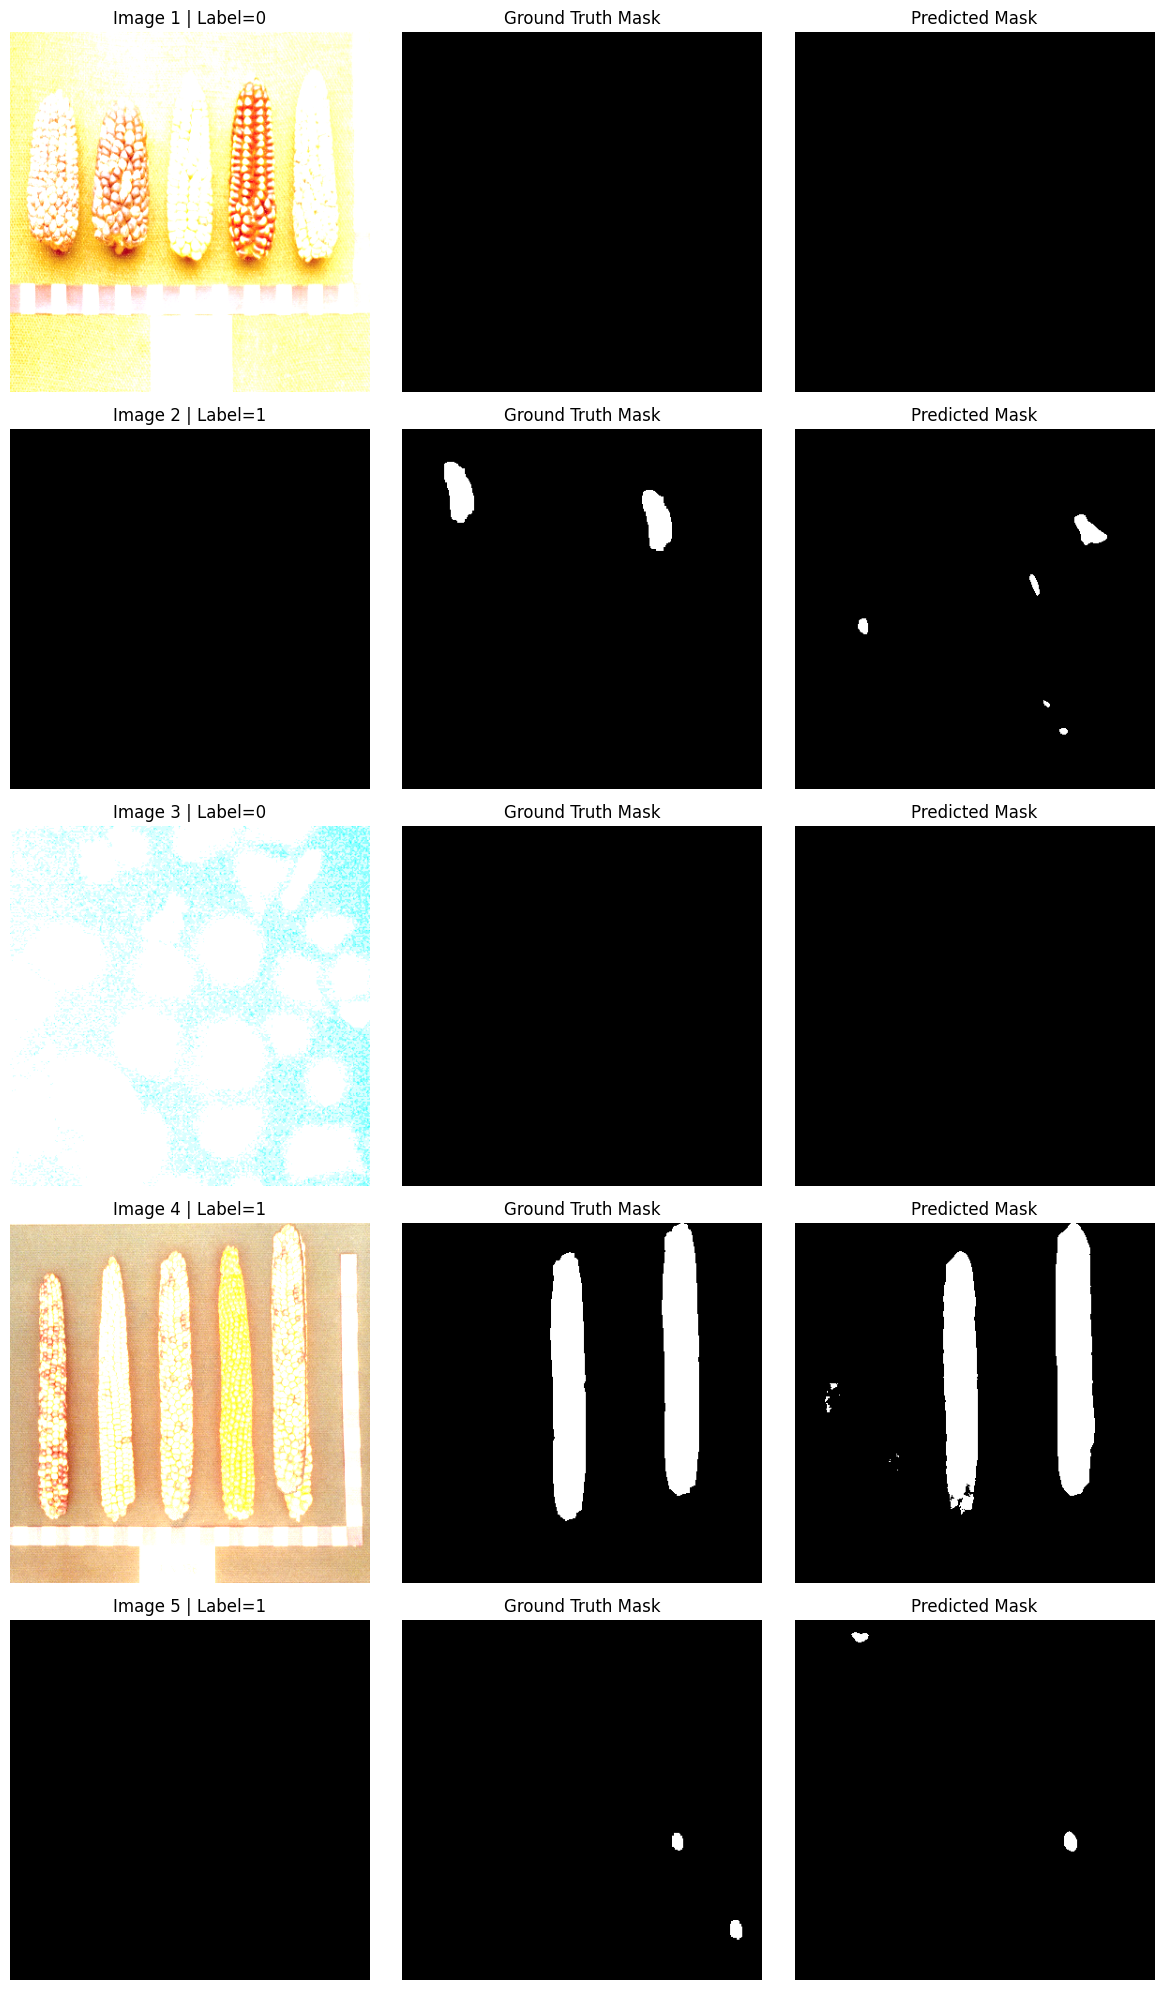

In [6]:
# =========================================================
# HYBRID FORGERY MODEL — FULL VISUALIZATION FILE
# =========================================================

import torch
import numpy as np
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp


# ---------------------------------------------------------
# DEVICE
# ---------------------------------------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)


# ---------------------------------------------------------
# 1. MODEL ARCHITECTURE
# ---------------------------------------------------------
class HybridForgeryModel(torch.nn.Module):
    def __init__(self, encoder_name="efficientnet-b3", pretrained=True):
        super().__init__()

        # U-Net encoder/decoder for segmentation
        self.seg_model = smp.Unet(
            encoder_name=encoder_name,
            encoder_weights="imagenet" if pretrained else None,
            in_channels=3,
            classes=1
        )

        # Classification head from deepest encoder features
        bottleneck = self.seg_model.encoder.out_channels[-1]
        self.classifier = torch.nn.Sequential(
            torch.nn.AdaptiveAvgPool2d(1),
            torch.nn.Flatten(),
            torch.nn.Linear(bottleneck, 256),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(256, 1)
        )

    def forward(self, x):
        enc_feats = self.seg_model.encoder(x)
        deep = enc_feats[-1]
        cls_logit = self.classifier(deep)

        dec = self.seg_model.decoder(enc_feats)
        seg = self.seg_model.segmentation_head(dec)

        return seg, cls_logit


# ---------------------------------------------------------
# 2. LOAD TRAINED WEIGHTS
# ---------------------------------------------------------
model = HybridForgeryModel().to(DEVICE)

checkpoint = torch.load("best_hybrid_stepB_v2.pth", map_location=DEVICE)
model.load_state_dict(checkpoint["model_state"])
print("Loaded model from epoch:", checkpoint["epoch"])

model.eval()


# ---------------------------------------------------------
# 3. VISUALIZATION FUNCTION
# ---------------------------------------------------------
def visualize_predictions(model, dataset, num_samples=5, device=DEVICE):
    model.eval()

    plt.figure(figsize=(12, num_samples * 4))

    for i in range(num_samples):
        img, mask, label = dataset[i]   # must match your dataset

        # move to device
        img_tensor = img.unsqueeze(0).to(device)

        # predict
        with torch.no_grad():
            pred_mask, pred_cls = model(img_tensor)
            pred_mask = torch.sigmoid(pred_mask)[0, 0].cpu().numpy()
            pred_mask = (pred_mask > 0.5).astype("float32")

        # prepare numpy images
        img_np = img.permute(1, 2, 0).cpu().numpy()
        img_np = (img_np - img_np.min()) / (img_np.max() + 1e-6)

        mask_np = mask.squeeze(0).cpu().numpy()

        # ------------------------------
        # PLOT IMAGE + MASKS
        # ------------------------------
        plt.subplot(num_samples, 3, 3*i + 1)
        plt.imshow(img_np)
        plt.title(f"Image {i+1} | Label={int(label)}")
        plt.axis("off")

        plt.subplot(num_samples, 3, 3*i + 2)
        plt.imshow(mask_np, cmap="gray")
        plt.title("Ground Truth Mask")
        plt.axis("off")

        plt.subplot(num_samples, 3, 3*i + 3)
        plt.imshow(pred_mask, cmap="gray")
        plt.title("Predicted Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


# ---------------------------------------------------------
# 4. RUN VISUALIZATION
# ---------------------------------------------------------
# val_ds MUST already exist in your notebook/script
visualize_predictions(model, val_ds, num_samples=5)


# fine tunning the hybrid model for accumulate other type of copy move forgery


In [13]:
import os, glob, random, time
import numpy as np
import cv2
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torch.amp import autocast, GradScaler
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2

from model import HybridForgeryModel, load_checkpoint

# ---------------- CONFIG ----------------
ROOT = r"Data"
COMO_ROOT = r"comofod_small/CoMoFoD_small_v2"

IMG_SIZE = 384
BATCH_SIZE = 4
NUM_WORKERS = 0   # Windows safe
EPOCHS = 15
LR = 1e-4
SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CLIP_GRAD_NORM = 5.0
CHECKPOINT_PATH = "best_hybrid_stepB_v2.pth"  # existing model

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# ---------------- Utility ----------------
def list_images(folder, exts=["*.png","*.jpg","*.jpeg","*.JPG","*.PNG"]):
    files = []
    for e in exts:
        files.extend(glob.glob(os.path.join(folder, e)))
    return sorted(files)

# ---------------- Dataset Classes ----------------
class ScientificDataset(Dataset):
    """Scientific dataset (images + masks)"""
    def __init__(self, img_paths, mask_paths, labels, transform=None):
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.labels = labels
        self.transform = transform

    def __len__(self): return len(self.img_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

        mask_path = self.mask_paths[idx]
        if mask_path:
            mask = np.load(mask_path)
            if mask.ndim == 3: mask = mask[0]
            mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
            mask = (mask > 0).astype("float32")
        else:
            mask = np.zeros((IMG_SIZE, IMG_SIZE), dtype="float32")

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented["image"]
            mask = augmented["mask"].unsqueeze(0).float()
        else:
            img = torch.tensor(img.transpose(2,0,1)/255.0, dtype=torch.float32)
            mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return img, mask, label

class CoMoFoDDataset(Dataset):
    """CoMoFoD dataset (images only, no masks)"""
    def __init__(self, img_folder, transform=None):
        self.transform = transform
        self.items = []
        files = list_images(img_folder)
        for f in files:
            base = os.path.basename(f)
            if "_F_" in base:
                label = 1
            elif "_O_" in base:
                label = 0
            else:
                continue
            self.items.append((f, None, label))

    def __len__(self): return len(self.items)

    def __getitem__(self, idx):
        img_path, _, label = self.items[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

        mask = np.zeros((IMG_SIZE, IMG_SIZE), dtype="float32")  # no masks

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented["image"]
            mask = augmented["mask"].unsqueeze(0).float()
        else:
            img = torch.tensor(img.transpose(2,0,1)/255.0, dtype=torch.float32)
            mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

        label = torch.tensor(label, dtype=torch.float32)
        return img, mask, label

# ---------------- Transforms ----------------
train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.06, scale_limit=0.08, rotate_limit=18, p=0.5),
    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=10, p=0.3),
    A.GridDistortion(p=0.3),
    A.RandomBrightnessContrast(p=0.4),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2(),
])

# ---------------- Prepare datasets ----------------
# Scientific dataset
auth_list = list_images(os.path.join(ROOT, "train_images", "authentic"))
forg_list = list_images(os.path.join(ROOT, "train_images", "forged"))
mask_list = glob.glob(os.path.join(ROOT, "train_masks", "*.npy"))
mask_dict = {os.path.basename(p).rsplit(".",1)[0]: p for p in mask_list}

items = []
for p in auth_list:
    items.append((p, None, 0))
for p in forg_list:
    base = os.path.basename(p).rsplit(".",1)[0]
    m = mask_dict.get(base, None)
    items.append((p, m, 1))

img_paths = [it[0] for it in items]
mask_paths = [it[1] for it in items]
labels = [it[2] for it in items]

sci_train_imgs, sci_val_imgs, sci_train_masks, sci_val_masks, sci_train_labels, sci_val_labels = train_test_split(
    img_paths, mask_paths, labels, test_size=0.2, stratify=labels, random_state=SEED
)

sci_train_ds = ScientificDataset(sci_train_imgs, sci_train_masks, sci_train_labels, transform=train_transform)
sci_val_ds   = ScientificDataset(sci_val_imgs, sci_val_masks, sci_val_labels, transform=val_transform)

# CoMoFoD dataset
com_train_imgs, com_val_imgs = train_test_split(
    list_images(COMO_ROOT),
    test_size=0.2, random_state=SEED
)
com_train_ds = CoMoFoDDataset(COMO_ROOT, transform=train_transform)
com_val_ds   = CoMoFoDDataset(COMO_ROOT, transform=val_transform)

# Mixed datasets
train_ds = ConcatDataset([sci_train_ds, com_train_ds])
val_ds   = ConcatDataset([sci_val_ds, com_val_ds])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# ---------------- Model ----------------
model = HybridForgeryModel().to(DEVICE)
model = load_checkpoint(model, CHECKPOINT_PATH, DEVICE)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-5)
scaler = GradScaler()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
bce_cls = nn.BCEWithLogitsLoss()

# Dice + Tversky for small masks
def tversky_loss(logits, target, alpha=0.7, beta=0.3, eps=1e-6):
    pred = torch.sigmoid(logits)
    TP = (pred * target).sum(dim=(2,3))
    FP = ((1-pred) * target).sum(dim=(2,3))
    FN = (pred * (1-target)).sum(dim=(2,3))
    tversky = (TP + eps) / (TP + alpha*FP + beta*FN + eps)
    return 1 - tversky.mean()

def combo_seg_loss(logits, target, bce_w=0.5, dice_w=0.5):
    target = target.float()
    dice = tversky_loss(logits, target)
    bce = F.binary_cross_entropy_with_logits(logits, target)
    return bce_w*bce + dice_w*dice

def dice_metric(pred_logits, target, thr=0.5, eps=1e-6):
    pred = (torch.sigmoid(pred_logits) > thr).float()
    inter = (pred*target).sum(dim=(1,2,3))
    union = pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3))
    dice = (2*inter+eps)/(union+eps)
    return dice.mean().item()

# ---------------- Train / Val loops ----------------
def train_one_epoch(epoch):
    model.train()
    losses, dices = [], []
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} [Train]", ncols=120)
    for imgs, masks, labels in pbar:
        imgs, masks, labels = imgs.to(DEVICE), masks.to(DEVICE), labels.to(DEVICE).unsqueeze(1)
        optimizer.zero_grad()
        with autocast(device_type="cuda"):
            seg_logits, cls_logits = model(imgs)
            seg_loss = combo_seg_loss(seg_logits, masks)
            cls_loss = bce_cls(cls_logits, labels)
            loss = seg_loss + 0.3*cls_loss

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_GRAD_NORM)
        scaler.step(optimizer)
        scaler.update()

        losses.append(loss.item())
        dices.append(dice_metric(seg_logits, masks))
        pbar.set_postfix({"loss": f"{np.mean(losses):.4f}", "dice": f"{np.mean(dices):.4f}"})
    return np.mean(losses), np.mean(dices)

def validate(epoch):
    model.eval()
    losses, dices = [], []
    with torch.no_grad():
        pbar = tqdm(val_loader, desc=f"Epoch {epoch}/{EPOCHS} [Val]", ncols=120)
        for imgs, masks, labels in pbar:
            imgs, masks, labels = imgs.to(DEVICE), masks.to(DEVICE), labels.to(DEVICE).unsqueeze(1)
            seg_logits, cls_logits = model(imgs)
            seg_loss = combo_seg_loss(seg_logits, masks)
            cls_loss = bce_cls(cls_logits, labels)
            loss = seg_loss + 0.3*cls_loss

            losses.append(loss.item())
            dices.append(dice_metric(seg_logits, masks))
            pbar.set_postfix({"val_loss": f"{np.mean(losses):.4f}", "val_dice": f"{np.mean(dices):.4f}"})
    return np.mean(losses), np.mean(dices)

# ---------------- Main ----------------
if __name__ == "__main__":
    best_val_dice = -1.0
    for epoch in range(1, EPOCHS+1):
        t0 = time.time()
        train_loss, train_dice = train_one_epoch(epoch)
        val_loss, val_dice = validate(epoch)
        scheduler.step()
        print(f"\nEpoch {epoch} time: {(time.time()-t0)/60:.2f} min")
        print(f"Train loss: {train_loss:.4f} | Train dice: {train_dice:.4f}")
        print(f"Val loss: {val_loss:.4f} | Val dice: {val_dice:.4f}")

        if val_dice > best_val_dice:
            best_val_dice = val_dice
            ckpt_path = f"checkpoints/finetuned_epoch{epoch}.pth"
            torch.save({
                "epoch": epoch,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "best_val_dice": best_val_dice
            }, ckpt_path)
            print("Saved best model ->", ckpt_path)

    print("Fine-tuning complete. Best Val Dice:", best_val_dice)


d:\Image_forgery_detection\venv\lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
C:\Users\amits_b2zbl1r\AppData\Local\Temp\ipykernel_24860\3569279598.py:120: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=10, p=0.3),
d:\Image_forgery_detection\model.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpicklin


Epoch 1 time: 36.77 min
Train loss: 0.6008 | Train dice: 0.6076
Val loss: 0.5749 | Val dice: 0.9049
Saved best model -> checkpoints/finetuned_epoch1.pth


Epoch 2/15 [Val]: 100%|███████████████████████████| 5313/5313 [08:41<00:00, 10.18it/s, val_loss=0.5303, val_dice=0.7898]



Epoch 2 time: 36.66 min
Train loss: 0.5531 | Train dice: 0.6767
Val loss: 0.5303 | Val dice: 0.7898


Epoch 3/15 [Val]: 100%|███████████████████████████| 5313/5313 [08:40<00:00, 10.20it/s, val_loss=0.5264, val_dice=0.9328]



Epoch 3 time: 36.55 min
Train loss: 0.5294 | Train dice: 0.7197
Val loss: 0.5264 | Val dice: 0.9328
Saved best model -> checkpoints/finetuned_epoch3.pth


Epoch 4/15 [Val]: 100%|███████████████████████████| 5313/5313 [08:38<00:00, 10.24it/s, val_loss=0.5181, val_dice=0.8323]



Epoch 4 time: 36.63 min
Train loss: 0.5227 | Train dice: 0.7397
Val loss: 0.5181 | Val dice: 0.8323


Epoch 5/15 [Val]: 100%|███████████████████████████| 5313/5313 [08:38<00:00, 10.24it/s, val_loss=0.5205, val_dice=0.9235]



Epoch 5 time: 36.62 min
Train loss: 0.5143 | Train dice: 0.7688
Val loss: 0.5205 | Val dice: 0.9235


Epoch 6/15 [Val]: 100%|███████████████████████████| 5313/5313 [08:39<00:00, 10.23it/s, val_loss=0.5121, val_dice=0.9049]



Epoch 6 time: 36.69 min
Train loss: 0.5085 | Train dice: 0.7632
Val loss: 0.5121 | Val dice: 0.9049


Epoch 7/15 [Val]: 100%|███████████████████████████| 5313/5313 [08:36<00:00, 10.28it/s, val_loss=0.5622, val_dice=0.9212]



Epoch 7 time: 36.57 min
Train loss: 0.5023 | Train dice: 0.7871
Val loss: 0.5622 | Val dice: 0.9212


Epoch 8/15 [Val]: 100%|███████████████████████████| 5313/5313 [08:39<00:00, 10.22it/s, val_loss=0.5194, val_dice=0.9114]



Epoch 8 time: 36.62 min
Train loss: 0.4984 | Train dice: 0.8083
Val loss: 0.5194 | Val dice: 0.9114


Epoch 9/15 [Val]: 100%|███████████████████████████| 5313/5313 [08:40<00:00, 10.20it/s, val_loss=0.5261, val_dice=0.9500]



Epoch 9 time: 36.49 min
Train loss: 0.4947 | Train dice: 0.8213
Val loss: 0.5261 | Val dice: 0.9500
Saved best model -> checkpoints/finetuned_epoch9.pth


Epoch 10/15 [Val]: 100%|██████████████████████████| 5313/5313 [08:40<00:00, 10.22it/s, val_loss=0.5149, val_dice=0.9620]



Epoch 10 time: 36.66 min
Train loss: 0.4896 | Train dice: 0.8257
Val loss: 0.5149 | Val dice: 0.9620
Saved best model -> checkpoints/finetuned_epoch10.pth


Epoch 11/15 [Val]: 100%|██████████████████████████| 5313/5313 [08:39<00:00, 10.22it/s, val_loss=0.5120, val_dice=0.9654]



Epoch 11 time: 36.59 min
Train loss: 0.4866 | Train dice: 0.8462
Val loss: 0.5120 | Val dice: 0.9654
Saved best model -> checkpoints/finetuned_epoch11.pth


Epoch 12/15 [Val]: 100%|██████████████████████████| 5313/5313 [08:38<00:00, 10.25it/s, val_loss=0.5100, val_dice=0.9563]



Epoch 12 time: 36.54 min
Train loss: 0.4829 | Train dice: 0.8572
Val loss: 0.5100 | Val dice: 0.9563


Epoch 13/15 [Val]: 100%|██████████████████████████| 5313/5313 [08:38<00:00, 10.24it/s, val_loss=0.5137, val_dice=0.9593]



Epoch 13 time: 36.52 min
Train loss: 0.4815 | Train dice: 0.8570
Val loss: 0.5137 | Val dice: 0.9593


Epoch 14/15 [Val]: 100%|██████████████████████████| 5313/5313 [08:40<00:00, 10.21it/s, val_loss=0.5140, val_dice=0.9647]



Epoch 14 time: 36.62 min
Train loss: 0.4792 | Train dice: 0.8607
Val loss: 0.5140 | Val dice: 0.9647


Epoch 15/15 [Val]: 100%|██████████████████████████| 5313/5313 [08:37<00:00, 10.27it/s, val_loss=0.5121, val_dice=0.9622]


Epoch 15 time: 36.57 min
Train loss: 0.4783 | Train dice: 0.8651
Val loss: 0.5121 | Val dice: 0.9622
Fine-tuning complete. Best Val Dice: 0.9653613668866016


In [1]:
# train_hybrid_deepsup.py
"""
HybridForgeryModel training with Multi-scale Deep Supervision
Windows-friendly version — uses smp Unet encoder + decoder and adds
auxiliary 1x1 heads on encoder feature maps for deep supervision.
"""

import os
import glob
import time
import random
import numpy as np
import cv2
from tqdm import tqdm
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast, GradScaler
from contextlib import nullcontext

from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp

# ---------------- CONFIG ----------------
ROOT = r"d:/Image_forgery_detection/Data"
IMG_SIZE = 256
BATCH_SIZE = 8
NUM_WORKERS = 0       # set >0 if your Windows/driver supports it
EPOCHS = 25
LR = 1e-4
SEED = 42
ENCODER = "efficientnet-b0"
PRETRAINED = True
SAVE_PATH = "best_hybrid_deepsup.pth"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# deep supervision weights
AUX_WEIGHT = 0.4      # total weight for all aux heads (will be averaged across heads)
CLS_WEIGHT = 0.3      # classification contribution to total loss

CLIP_GRAD_NORM = 5.0

# reproducibility
random.seed(SEED)
np.random.seed(SEED)

torch.manual_seed(SEED)
if torch.cuda.is_available():
    try:
        torch.cuda.manual_seed_all(SEED)
    except:
        print("WARNING: CUDA seed failed")



print("DEVICE:", DEVICE, "torch:", torch.__version__)

# ---------------- helpers: list images ----------------
def list_images(folder):
    exts = ["*.png", "*.jpg", "*.jpeg", "*.PNG", "*.JPG", "*.JPEG"]
    files = []
    for e in exts:
        files.extend(glob.glob(os.path.join(folder, e)))
    return sorted(files)

# ---------------- build dataset lists ----------------
auth_dir = os.path.join(ROOT, "train_images", "authentic")
forg_dir = os.path.join(ROOT, "train_images", "forged")
mask_dir = os.path.join(ROOT, "train_masks")

assert os.path.exists(auth_dir), f"Missing {auth_dir}"
assert os.path.exists(forg_dir), f"Missing {forg_dir}"
assert os.path.exists(mask_dir), f"Missing {mask_dir}"

auth_list = list_images(auth_dir)
forg_list = list_images(forg_dir)
mask_list = sorted(glob.glob(os.path.join(mask_dir, "*.npy")))
mask_dict = {os.path.basename(p).rsplit(".", 1)[0]: p for p in mask_list}

items = []
for p in auth_list:
    items.append((p, None, 0))
for p in forg_list:
    base = os.path.basename(p).rsplit(".", 1)[0]
    m = mask_dict.get(base, None)
    if m is None:
        # warn but still include (some forged images may be missing mask)
        print("WARN: missing mask for", base)
    items.append((p, m, 1))

print("TOTAL images:", len(items), "masks(found):", sum(1 for it in items if it[1] is not None))

# ---------------- split ----------------
img_paths = [it[0] for it in items]
mask_paths = [it[1] for it in items]
labels = [it[2] for it in items]

train_imgs, val_imgs, train_masks, val_masks, train_labels, val_labels = train_test_split(
    img_paths, mask_paths, labels, test_size=0.2, stratify=labels, random_state=SEED
)

print("Train/Val:", len(train_imgs), "/", len(val_imgs))
print("Train forged ratio:", sum(train_labels)/len(train_labels))

# ---------------- dataset ----------------
class ForgeryDataset(Dataset):
    def __init__(self, image_paths, mask_paths, labels, transform=None, size=(IMG_SIZE, IMG_SIZE)):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.labels = labels
        self.transform = transform
        self.size = size

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        p = self.image_paths[idx]
        img = cv2.imread(p)
        if img is None:
            raise RuntimeError(f"Failed to read image {p}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, self.size, interpolation=cv2.INTER_AREA)

        mpath = self.mask_paths[idx]
        if mpath is not None and os.path.exists(mpath):
            mask = np.load(mpath)
            if mask.ndim == 3:
                mask = mask[0]
            mask = cv2.resize(mask, self.size, interpolation=cv2.INTER_NEAREST)
            mask = (mask > 0).astype("uint8")
        else:
            mask = np.zeros(self.size, dtype="uint8")

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented["image"]
            mask = augmented["mask"]
            # ToTensorV2 may return torch tensor for mask or numpy array depending on config
            if isinstance(mask, np.ndarray):
                mask = torch.from_numpy(mask).unsqueeze(0).float()
            else:
                # mask is a tensor (H,W) or (1,H,W)
                if mask.ndim == 2:
                    mask = mask.unsqueeze(0).float()
                else:
                    mask = mask.float()
        else:
            img = torch.from_numpy(img).permute(2,0,1).float() / 255.0
            mask = torch.from_numpy(mask).unsqueeze(0).float()

        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return img, mask, label

# ---------------- transforms ----------------
train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.06, scale_limit=0.08, rotate_limit=18, p=0.5),
    A.RandomBrightnessContrast(p=0.4),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2(),
])

# ---------------- dataloaders ----------------
train_ds = ForgeryDataset(train_imgs, train_masks, train_labels, transform=train_transform)
val_ds = ForgeryDataset(val_imgs, val_masks, val_labels, transform=val_transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=NUM_WORKERS, pin_memory=True)

print("Train batches:", len(train_loader), "Val batches:", len(val_loader))

# ---------------- model with aux heads (deepsup) ----------------
class HybridForgeryDeepsup(nn.Module):
    def __init__(self, encoder_name=ENCODER, pretrained=PRETRAINED, aux_on_encoder_stages=(1,2,3,4)):
        """
        aux_on_encoder_stages indicates which encoder outputs to attach aux heads to.
        encoder returns a list of feature maps; stage index 0 is earliest (high-res).
        We'll avoid stage 0 (very fine) and instead use later stages typically useful.
        """
        super().__init__()
        # main U-Net (encoder+decoder)
        self.seg_model = smp.Unet(
            encoder_name=encoder_name,
            encoder_weights="imagenet" if pretrained else None,
            in_channels=3,
            classes=1
        )

        # encoder feature channel dims
        enc_chs = self.seg_model.encoder.out_channels  # list e.g. [32, 64, 160, 272, 512] (depends on encoder)
        self.enc_chs = enc_chs
        # choose stages for auxiliary supervision (must be valid indices)
        self.aux_stages = [s for s in aux_on_encoder_stages if 0 <= s < len(enc_chs)]

        # create aux 1x1 conv heads that map enc_features -> 1 channel
        self.aux_heads = nn.ModuleList([
            nn.Conv2d(enc_chs[s], 1, kernel_size=1) for s in self.aux_stages
        ])

        # classification head (use deepest encoder feature)
        bottleneck = enc_chs[-1]
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(bottleneck, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        # x: (B,3,H,W)
        # get encoder features (list)
        enc_feats = self.seg_model.encoder(x)
        # classification uses deepest encoder feature
        deep = enc_feats[-1]
        cls_logit = self.classifier(deep)

        # main segmentation: feed encoder features into decoder
        dec = self.seg_model.decoder(enc_feats)    # decoder expects list
        seg = self.seg_model.segmentation_head(dec) # (B,1,H_out,W_out)

        # auxiliary preds: run aux heads on selected encoder features and upsample to seg size
        aux_preds = []
        for idx, stage in enumerate(self.aux_stages):
            feat = enc_feats[stage]               # (B,C,H_s,W_s)
            out = self.aux_heads[idx](feat)      # (B,1,H_s,W_s)
            # upsample to seg size (use bilinear then treat as logits)
            out_up = F.interpolate(out, size=seg.shape[2:], mode="bilinear", align_corners=False)
            aux_preds.append(out_up)             # logits
        return seg, aux_preds, cls_logit

# instantiate
model = HybridForgeryDeepsup().to(DEVICE)
print("Model params (M): %.6f" % (sum(p.numel() for p in model.parameters())/1e6))

# optional channels_last
try:
    model.to(memory_format=torch.channels_last)
    print("Set model to channels_last.")
except Exception:
    pass

# ---------------- LOSS / OPTIMIZER / AMP ----------------
bce_cls = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-5)
scaler = GradScaler()

def dice_loss_from_logits(logits, target, eps=1e-6):
    pred = torch.sigmoid(logits)
    inter = (pred * target).sum(dim=(2,3))
    denom = pred.sum(dim=(2,3)) + target.sum(dim=(2,3))
    dice = (2*inter + eps) / (denom + eps)
    return 1 - dice.mean()

def combo_seg_loss_stable(logits, target, bce_w=0.5, dice_w=0.5):
    # logits: (B,1,H,W), target: (B,1,H,W)
    target = target.float()
    bce = F.binary_cross_entropy_with_logits(logits, target)
    dice_l = dice_loss_from_logits(logits, target)
    return bce_w * bce + dice_w * dice_l, float(bce.detach().cpu()), float(dice_l)

def dice_metric_batch(pred_logits, target, thr=0.5, eps=1e-6):
    pred = (torch.sigmoid(pred_logits) > thr).float()
    inter = (pred * target).sum(dim=(1,2,3))
    union = pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3))
    dice = (2*inter + eps) / (union + eps)
    return dice.mean().item()

# choose autocast context safely (works CPU or CUDA)
if torch.cuda.is_available():
    autocast_ctx = lambda : autocast(device_type="cuda")
else:
    autocast_ctx = lambda : nullcontext()

# ---------------- TRAIN / VALID functions ----------------
def train_one_epoch(epoch):
    model.train()
    losses = []
    dices = []
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} [Train]", ncols=120)
    for imgs, masks, labels in pbar:
        imgs = imgs.to(DEVICE)
        # if channels_last is used: convert input memory format (best-effort)
        try:
            imgs = imgs.to(memory_format=torch.channels_last)
        except Exception:
            pass
        masks = masks.to(DEVICE)
        labels = labels.to(DEVICE).unsqueeze(1)

        optimizer.zero_grad()
        with autocast_ctx():
            seg_logits, aux_preds, cls_logits = model(imgs)
            main_loss, main_bce, main_dice_loss = combo_seg_loss_stable(seg_logits, masks)
            # aux losses (average them)
            aux_loss_vals = []
            for aux in aux_preds:
                al, _, _ = combo_seg_loss_stable(aux, masks)
                aux_loss_vals.append(al)
            aux_loss = (torch.stack(aux_loss_vals).mean() if aux_loss_vals else 0.0)
            cls_loss = bce_cls(cls_logits, labels)
            total_loss = main_loss + AUX_WEIGHT * aux_loss + CLS_WEIGHT * cls_loss

        # skip bad batches
        if torch.isnan(total_loss) or torch.isinf(total_loss):
            print("WARNING: NaN/Inf loss at train batch — skipping")
            continue

        scaler.scale(total_loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_GRAD_NORM)
        scaler.step(optimizer)
        scaler.update()

        losses.append(total_loss.item())
        dices.append(dice_metric_batch(seg_logits.detach(), masks.detach()))
        pbar.set_postfix({
            "loss": f"{np.mean(losses):.4f}",
            "dice": f"{np.mean(dices):.4f}"
        })
    return np.mean(losses) if losses else float("nan"), np.mean(dices) if dices else 0.0

def validate(epoch):
    model.eval()
    losses = []
    dices = []
    with torch.no_grad():
        pbar = tqdm(val_loader, desc=f"Epoch {epoch}/{EPOCHS} [Val]", ncols=120)
        for imgs, masks, labels in pbar:
            imgs = imgs.to(DEVICE)
            try:
                imgs = imgs.to(memory_format=torch.channels_last)
            except Exception:
                pass
            masks = masks.to(DEVICE)
            labels = labels.to(DEVICE).unsqueeze(1)

            seg_logits, aux_preds, cls_logits = model(imgs)
            main_loss, _, _ = combo_seg_loss_stable(seg_logits, masks)
            aux_loss_vals = []
            for aux in aux_preds:
                al, _, _ = combo_seg_loss_stable(aux, masks)
                aux_loss_vals.append(al)
            aux_loss = (torch.stack(aux_loss_vals).mean() if aux_loss_vals else 0.0)
            cls_loss = bce_cls(cls_logits, labels)
            total_loss = main_loss + AUX_WEIGHT * aux_loss + CLS_WEIGHT * cls_loss

            losses.append(total_loss.item())
            dices.append(dice_metric_batch(seg_logits, masks))
            pbar.set_postfix({
                "val_loss": f"{np.mean(losses):.4f}",
                "val_dice": f"{np.mean(dices):.4f}"
            })
    return np.mean(losses) if losses else float("nan"), np.mean(dices) if dices else 0.0

# ---------------- MAIN ----------------
if __name__ == "__main__":
    best_val_dice = -1.0
    for epoch in range(1, EPOCHS + 1):
        t0 = time.time()
        train_loss, train_dice = train_one_epoch(epoch)
        val_loss, val_dice = validate(epoch)

        print(f"\nEpoch {epoch} finished in {(time.time()-t0)/60:.2f} min")
        print(f"Train loss: {train_loss:.4f} | Train dice: {train_dice:.4f}")
        print(f"Val   loss: {val_loss:.4f} | Val   dice: {val_dice:.4f}")

        if not math.isnan(val_dice) and val_dice > best_val_dice:
            best_val_dice = val_dice
            torch.save({
                "epoch": epoch,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "best_val_dice": best_val_dice
            }, SAVE_PATH)
            print("Saved best model ->", SAVE_PATH)

    print("Training complete. Best Val Dice:", best_val_dice)


d:\Image_forgery_detection\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DEVICE: cuda torch: 2.5.1+cu121
TOTAL images: 10256 masks(found): 5502
Train/Val: 8204 / 2052
Train forged ratio: 0.5364456362749878
Train batches: 1026 Val batches: 257


d:\Image_forgery_detection\venv\lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Model params (M): 6.334114
Set model to channels_last.


Epoch 1/25 [Val]: 100%|█████████████████████████████| 257/257 [01:07<00:00,  3.80it/s, val_loss=0.9285, val_dice=0.2855]



Epoch 1 finished in 10.82 min
Train loss: 1.1083 | Train dice: 0.1506
Val   loss: 0.9285 | Val   dice: 0.2855
Saved best model -> best_hybrid_deepsup.pth


Epoch 2/25 [Val]: 100%|█████████████████████████████| 257/257 [01:06<00:00,  3.87it/s, val_loss=0.8349, val_dice=0.3062]



Epoch 2 finished in 10.72 min
Train loss: 0.8949 | Train dice: 0.2499
Val   loss: 0.8349 | Val   dice: 0.3062
Saved best model -> best_hybrid_deepsup.pth


Epoch 3/25 [Val]: 100%|█████████████████████████████| 257/257 [01:06<00:00,  3.85it/s, val_loss=0.8036, val_dice=0.3771]



Epoch 3 finished in 10.79 min
Train loss: 0.8399 | Train dice: 0.2954
Val   loss: 0.8036 | Val   dice: 0.3771
Saved best model -> best_hybrid_deepsup.pth


Epoch 4/25 [Val]: 100%|█████████████████████████████| 257/257 [01:06<00:00,  3.85it/s, val_loss=0.7805, val_dice=0.3843]



Epoch 4 finished in 10.78 min
Train loss: 0.8149 | Train dice: 0.3032
Val   loss: 0.7805 | Val   dice: 0.3843
Saved best model -> best_hybrid_deepsup.pth


Epoch 5/25 [Val]: 100%|█████████████████████████████| 257/257 [01:06<00:00,  3.88it/s, val_loss=0.7760, val_dice=0.4028]



Epoch 5 finished in 10.81 min
Train loss: 0.7997 | Train dice: 0.3200
Val   loss: 0.7760 | Val   dice: 0.4028
Saved best model -> best_hybrid_deepsup.pth


Epoch 6/25 [Val]: 100%|█████████████████████████████| 257/257 [01:05<00:00,  3.93it/s, val_loss=0.7564, val_dice=0.4049]



Epoch 6 finished in 10.78 min
Train loss: 0.7847 | Train dice: 0.3343
Val   loss: 0.7564 | Val   dice: 0.4049
Saved best model -> best_hybrid_deepsup.pth


Epoch 7/25 [Val]: 100%|█████████████████████████████| 257/257 [01:04<00:00,  3.98it/s, val_loss=0.7491, val_dice=0.4195]



Epoch 7 finished in 10.80 min
Train loss: 0.7751 | Train dice: 0.3571
Val   loss: 0.7491 | Val   dice: 0.4195
Saved best model -> best_hybrid_deepsup.pth


Epoch 8/25 [Val]: 100%|█████████████████████████████| 257/257 [01:05<00:00,  3.93it/s, val_loss=0.7501, val_dice=0.4485]



Epoch 8 finished in 10.80 min
Train loss: 0.7640 | Train dice: 0.3696
Val   loss: 0.7501 | Val   dice: 0.4485
Saved best model -> best_hybrid_deepsup.pth


Epoch 9/25 [Val]: 100%|█████████████████████████████| 257/257 [01:06<00:00,  3.86it/s, val_loss=0.7340, val_dice=0.3983]



Epoch 9 finished in 10.81 min
Train loss: 0.7595 | Train dice: 0.3728
Val   loss: 0.7340 | Val   dice: 0.3983


Epoch 10/25 [Val]: 100%|████████████████████████████| 257/257 [01:06<00:00,  3.89it/s, val_loss=0.7333, val_dice=0.4621]



Epoch 10 finished in 10.73 min
Train loss: 0.7485 | Train dice: 0.3829
Val   loss: 0.7333 | Val   dice: 0.4621
Saved best model -> best_hybrid_deepsup.pth


Epoch 11/25 [Val]: 100%|████████████████████████████| 257/257 [01:06<00:00,  3.88it/s, val_loss=0.7329, val_dice=0.4935]



Epoch 11 finished in 10.71 min
Train loss: 0.7424 | Train dice: 0.4035
Val   loss: 0.7329 | Val   dice: 0.4935
Saved best model -> best_hybrid_deepsup.pth


Epoch 12/25 [Val]: 100%|████████████████████████████| 257/257 [01:06<00:00,  3.88it/s, val_loss=0.7328, val_dice=0.4845]



Epoch 12 finished in 10.78 min
Train loss: 0.7390 | Train dice: 0.4138
Val   loss: 0.7328 | Val   dice: 0.4845


Epoch 13/25 [Val]: 100%|████████████████████████████| 257/257 [01:05<00:00,  3.92it/s, val_loss=0.7339, val_dice=0.4755]



Epoch 13 finished in 10.77 min
Train loss: 0.7327 | Train dice: 0.4236
Val   loss: 0.7339 | Val   dice: 0.4755


Epoch 14/25 [Val]: 100%|████████████████████████████| 257/257 [01:06<00:00,  3.85it/s, val_loss=0.7237, val_dice=0.4962]



Epoch 14 finished in 10.72 min
Train loss: 0.7256 | Train dice: 0.4197
Val   loss: 0.7237 | Val   dice: 0.4962
Saved best model -> best_hybrid_deepsup.pth


Epoch 15/25 [Val]: 100%|████████████████████████████| 257/257 [01:05<00:00,  3.94it/s, val_loss=0.7226, val_dice=0.4875]



Epoch 15 finished in 10.78 min
Train loss: 0.7243 | Train dice: 0.4128
Val   loss: 0.7226 | Val   dice: 0.4875


Epoch 16/25 [Val]: 100%|████████████████████████████| 257/257 [01:05<00:00,  3.90it/s, val_loss=0.7318, val_dice=0.4709]



Epoch 16 finished in 10.78 min
Train loss: 0.7155 | Train dice: 0.4453
Val   loss: 0.7318 | Val   dice: 0.4709


Epoch 17/25 [Val]: 100%|████████████████████████████| 257/257 [01:05<00:00,  3.92it/s, val_loss=0.7189, val_dice=0.5072]



Epoch 17 finished in 10.71 min
Train loss: 0.7114 | Train dice: 0.4502
Val   loss: 0.7189 | Val   dice: 0.5072
Saved best model -> best_hybrid_deepsup.pth


Epoch 18/25 [Val]: 100%|████████████████████████████| 257/257 [01:06<00:00,  3.88it/s, val_loss=0.7178, val_dice=0.4707]



Epoch 18 finished in 10.85 min
Train loss: 0.7083 | Train dice: 0.4551
Val   loss: 0.7178 | Val   dice: 0.4707


Epoch 19/25 [Val]: 100%|████████████████████████████| 257/257 [01:04<00:00,  4.01it/s, val_loss=0.7205, val_dice=0.5118]



Epoch 19 finished in 10.77 min
Train loss: 0.7041 | Train dice: 0.4651
Val   loss: 0.7205 | Val   dice: 0.5118
Saved best model -> best_hybrid_deepsup.pth


Epoch 20/25 [Val]: 100%|████████████████████████████| 257/257 [01:04<00:00,  3.96it/s, val_loss=0.7187, val_dice=0.5221]



Epoch 20 finished in 10.70 min
Train loss: 0.6988 | Train dice: 0.4697
Val   loss: 0.7187 | Val   dice: 0.5221
Saved best model -> best_hybrid_deepsup.pth


Epoch 21/25 [Val]: 100%|████████████████████████████| 257/257 [01:05<00:00,  3.92it/s, val_loss=0.7060, val_dice=0.5569]



Epoch 21 finished in 10.78 min
Train loss: 0.6962 | Train dice: 0.4716
Val   loss: 0.7060 | Val   dice: 0.5569
Saved best model -> best_hybrid_deepsup.pth


Epoch 22/25 [Val]: 100%|████████████████████████████| 257/257 [01:04<00:00,  3.96it/s, val_loss=0.7095, val_dice=0.5183]



Epoch 22 finished in 10.77 min
Train loss: 0.6907 | Train dice: 0.4897
Val   loss: 0.7095 | Val   dice: 0.5183


Epoch 23/25 [Val]: 100%|████████████████████████████| 257/257 [01:06<00:00,  3.87it/s, val_loss=0.7073, val_dice=0.5398]



Epoch 23 finished in 10.79 min
Train loss: 0.6868 | Train dice: 0.4818
Val   loss: 0.7073 | Val   dice: 0.5398


Epoch 24/25 [Val]: 100%|████████████████████████████| 257/257 [01:05<00:00,  3.94it/s, val_loss=0.6973, val_dice=0.5359]



Epoch 24 finished in 10.70 min
Train loss: 0.6844 | Train dice: 0.4911
Val   loss: 0.6973 | Val   dice: 0.5359


Epoch 25/25 [Val]: 100%|████████████████████████████| 257/257 [01:06<00:00,  3.88it/s, val_loss=0.6961, val_dice=0.5605]



Epoch 25 finished in 10.79 min
Train loss: 0.6811 | Train dice: 0.5029
Val   loss: 0.6961 | Val   dice: 0.5605
Saved best model -> best_hybrid_deepsup.pth
Training complete. Best Val Dice: 0.5605228146690339
